# Plot radial brightness profiles of the CO lines to infer the emission extent

In [48]:
import matplotlib.pylab as plt
import numpy as np

from astropy import units as u
from astropy.io import fits
from astropy.wcs import WCS
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy.nddata import Cutout2D
from astropy import modeling

from scipy.ndimage import rotate
from scipy.stats import norm
from scipy.interpolate import InterpolatedUnivariateSpline as spl


%matplotlib inline
%load_ext autoreload
%autoreload 2

PS1_data_path = '/Users/kristina/Hamburgers/Draculas_Chivito/Pan-STARRS_fits_files/'
SMA_data_path = '/Users/kristina/Hamburgers/Draculas_Chivito/SMA/data/'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def deconvolve_FWHM(FWHM_PSF, FWHM_obs):
    """
    Formula to 'deconvolve' the observed beam from the instrumental beam
    """
    return np.sqrt(FWHM_obs**2. - FWHM_PSF**2.)

In [3]:
### define DraChi's sky coordinates in WCS and later we'll convert them into pixel coordinates for every individual image
DraChi_coord = SkyCoord(ra='23:09:43.645', dec='+67:23:38.94', unit=(u.hourangle, u.deg))
DraChi_coord

<SkyCoord (ICRS): (ra, dec) in deg
    (347.43185417, 67.39415)>

### Pan-STARRS g-band

this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]


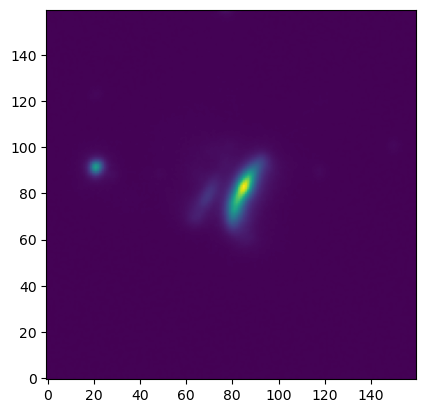

In [5]:
### load in data
gband_file = PS1_data_path+'cutout_rings.v3.skycell.2537.088.stk.g.unconv.fits'
gband = fits.open(gband_file)
wcs = WCS(gband[0].header)
gband_data = gband[0].data
gband_header = gband[0].header
gband = np.array(gband_data)

plt.imshow(gband_data, origin='lower')

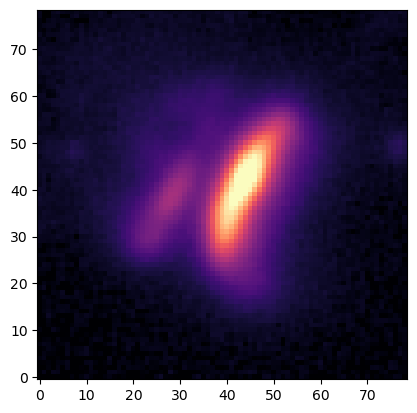

In [6]:
### convert IRAS sky position into PS1 pixel coordinates
x, y = wcs.world_to_pixel(DraChi_coord)

### get PS1 pixel scale
x_pixscale = gband_header['CDELT1']*60.*60.*u.arcsec # arcsec per pixel
y_pixscale = gband_header['CDELT2']*60.*60.*u.arcsec # arcsec per pixel

### define a box size for the cutout of the fits file
len_box_x = 20.*u.arcsec / x_pixscale
len_box_y = 20.*u.arcsec / y_pixscale

position = (int(x),int(y)) # x,y pixels
size = (int(len_box_y),int(len_box_x)) # ny, nx pixels

### make a cutout image that is only centered on the region of interest
cutout_gband = Cutout2D(np.array(gband_data), position, size)

norm = ImageNormalize(stretch=SqrtStretch(), vmin=0, vmax=5e4)  
plt.imshow(cutout_gband.data, origin='lower', cmap='magma', interpolation='nearest', norm=norm)

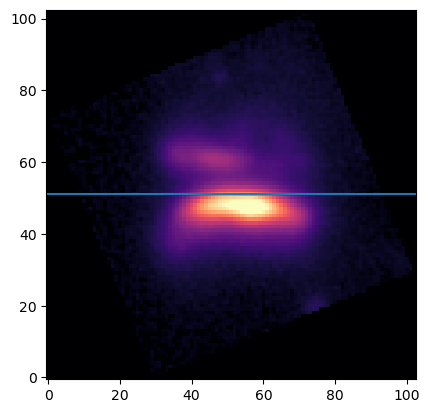

In [10]:
### now rotate the cube so that the disk midplane is horizontal
PA_disk = 338.
PA = PA_disk+90. 

PS1_gband_rotated = rotate(cutout_gband.data, PA)

norm = ImageNormalize(stretch=SqrtStretch(), vmin=0, vmax=5e4)  
plt.imshow(PS1_gband_rotated, origin='lower', cmap='magma', interpolation='nearest', norm=norm)

idx_center_gband = int(len(PS1_gband_rotated)/2.)
plt.axhline(idx_center_gband)

-7.513638820576761 8.776651864172853 8.145145342374807


Text(0.5, 1.0, 'PS1 g-band')

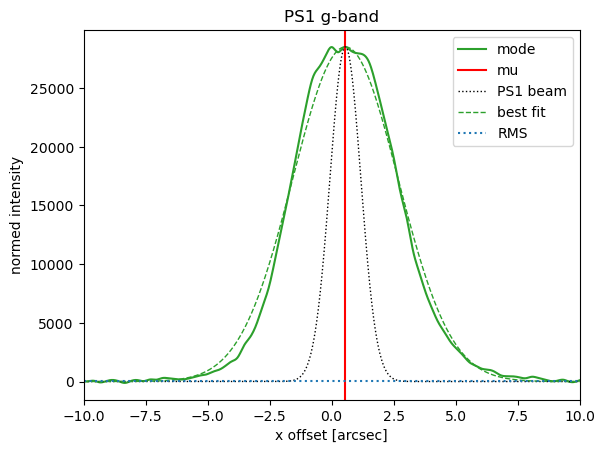

In [27]:
# center all lines to their maximum and "stack" them onto one position
old_grid_gband = np.linspace(0,PS1_gband_rotated.shape[1],PS1_gband_rotated.shape[1])
new_grid_gband = np.linspace(0,PS1_gband_rotated.shape[1],1000)
new_grid_centered_gband = (new_grid_gband-np.max(new_grid_gband)/2.)*(gband_header['CDELT1']*u.deg).to(u.arcsec).value

list_centered_gband = []
for i in range(len(PS1_gband_rotated)):
    model = spl(old_grid_gband, PS1_gband_rotated[i], ext=1)
    list_centered_gband.append(model(new_grid_gband))
list_centered_gband = np.array(list_centered_gband)   

mean_list_centered_gband = np.mean(list_centered_gband, axis=0)
median_list_centered_gband = np.median(list_centered_gband, axis=0)
std_list_centered_gband = np.std(list_centered_gband, axis=0)

plt.plot(new_grid_centered_gband, list_centered_gband[idx_center_gband], label='mode', c='C2')

### overplot Gaussian
x_axis = np.arange(-15, 15, 0.001)
mu_gband = new_grid_centered_gband[np.where(list_centered_gband[idx_center_gband]==np.max(list_centered_gband[idx_center_gband]))]
plt.axvline(mu_gband, ls='-', c='red', label='mu')

# overplot Gaussian for the PS1 beam 
FWHM_gband = 1.47 # arcsec, median PSF in g-band, cf. Table 11 in Chambers+2016 https://arxiv.org/pdf/1612.05560.pdf
plt.plot(x_axis, norm.pdf(x_axis,mu_gband,FWHM_gband/2.355)/np.max(norm.pdf(x_axis,0.,FWHM_gband/2.355))*np.max(list_centered_gband[idx_center_gband]), c='black', ls=':', lw=1, label='PS1 beam')

# overplot Gaussian with width of profile
FWHM = 5.0 # arcsec
plt.plot(x_axis, norm.pdf(x_axis,mu_gband,FWHM/2.355)/np.max(norm.pdf(x_axis,0.,FWHM/2.355))*np.max(list_centered_gband[idx_center_gband]), c='C2', ls='--', lw=1, label='best fit')

rms_gband = 70.8331
plt.axhline(rms_gband, ls=':', label='RMS')
idx_noise = np.where(list_centered_gband[idx_center_gband] <= rms_gband)

noise_left = new_grid_centered_gband[idx_noise][np.where(new_grid_centered_gband[idx_noise] < mu_gband)]
noise_right = new_grid_centered_gband[idx_noise][np.where(new_grid_centered_gband[idx_noise] >= mu_gband)]
print(np.max(noise_left), np.min(noise_right), (np.abs(np.max(noise_left))+np.min(noise_right))/2)

plt.xlabel('x offset [arcsec]')
plt.ylabel('normed intensity')
plt.xlim(-10,10)
plt.legend()
plt.title('PS1 g-band')

FWHM, mean, sigma, amplitude:  4.701521488423409 0.5445551207275133 1.9965523473202882 29856.995153989123
deconvolved FWHM, sigma =  4.4658038812857725 1.8963073805884385
2*sigma, 3*sigma:  3.792614761176877 5.688922141765316


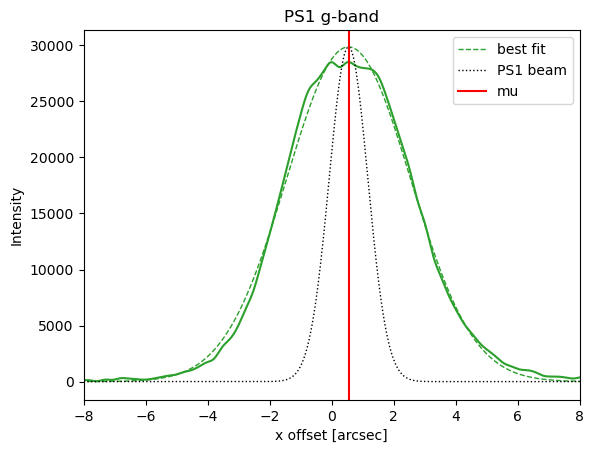

In [28]:
### use astropy to fit a Gaussian now (since the syntax is easier)  
fitter = modeling.fitting.LevMarLSQFitter()
model = modeling.models.Gaussian1D()   # depending on the data you need to give some initial values
fitted_model_gband = fitter(model, new_grid_centered_gband, list_centered_gband[idx_center_gband])

print('FWHM, mean, sigma, amplitude: ', fitted_model_gband.fwhm, fitted_model_gband.mean[0], fitted_model_gband.stddev[0], fitted_model_gband.amplitude[0])

plt.plot(new_grid_centered_gband, list_centered_gband[idx_center_gband], c='C2')
plt.plot(new_grid_centered_gband, fitted_model_gband(new_grid_centered_gband), c='C2', ls='--', lw=1, label='best fit')

# overplot Gaussian for the PS1 beam 
FWHM_gband = 1.47 # arcsec, median PSF in g-band, cf. Table 11 in Chambers+2016 https://arxiv.org/pdf/1612.05560.pdf
plt.plot(x_axis, norm.pdf(x_axis,fitted_model_gband.mean[0],FWHM_gband/2.355)/np.max(norm.pdf(x_axis,fitted_model_gband.mean[0],FWHM_gband/2.355))*np.max(fitted_model_gband(new_grid_centered_gband)), c='black', ls=':', lw=1, label='PS1 beam')

plt.axvline(fitted_model_gband.mean[0], ls='-', c='red', label='mu')

plt.xlabel('x offset [arcsec]')
plt.ylabel('Intensity')
plt.xlim(-8,8)
plt.legend()
plt.title('PS1 g-band')

FWHM_deconv = deconvolve_FWHM(FWHM_gband, fitted_model_gband.fwhm)
sigma_deconv = FWHM_deconv/2.355
print('deconvolved FWHM, sigma = ', FWHM_deconv, sigma_deconv)
print('2*sigma, 3*sigma: ', 2*sigma_deconv, 3*sigma_deconv)


### PS1 r-band

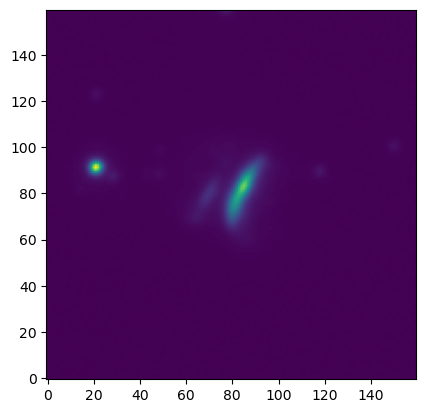

In [30]:
### load in data
rband_file = PS1_data_path+'cutout_rings.v3.skycell.2537.088.stk.r.unconv.fits'
rband = fits.open(rband_file)
wcs = WCS(rband[0].header)
rband_data = rband[0].data
rband_header = rband[0].header
rband = np.array(rband_data)

plt.imshow(rband_data, origin='lower')

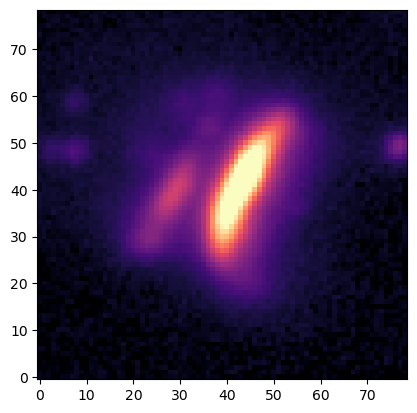

In [31]:
### convert IRAS sky position into PS1 pixel coordinates
x, y = wcs.world_to_pixel(DraChi_coord)

### get PS1 pixel scale
x_pixscale = rband_header['CDELT1']*60.*60.*u.arcsec # arcsec per pixel
y_pixscale = rband_header['CDELT2']*60.*60.*u.arcsec # arcsec per pixel

len_box_x = 20.*u.arcsec / x_pixscale
len_box_y = 20.*u.arcsec / y_pixscale

position = (int(x),int(y)) # x,y pixels
size = (int(len_box_y),int(len_box_x)) # ny, nx pixels

cutout_rband = Cutout2D(np.array(rband_data), position, size)

norm = ImageNormalize(stretch=SqrtStretch(), vmin=0, vmax=5e4)  
plt.imshow(cutout_rband.data, origin='lower', cmap='magma', interpolation='nearest', norm=norm)

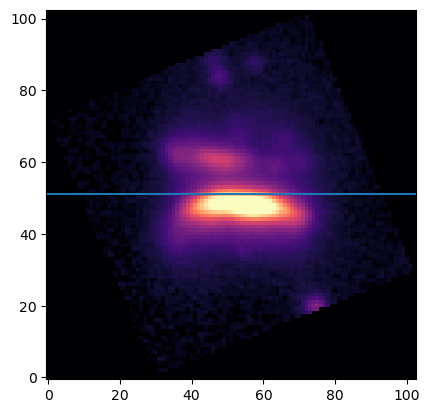

In [32]:
### now rotate the cube
PA_disk = 338.
PA = PA_disk+90.

PS1_rband_rotated = rotate(cutout_rband.data, PA)

norm = ImageNormalize(stretch=SqrtStretch(), vmin=0, vmax=5e4)  
plt.imshow(PS1_rband_rotated, origin='lower', cmap='magma', interpolation='nearest', norm=norm)

idx_center_rband = int(len(PS1_rband_rotated)/2.)
plt.axhline(idx_center_rband)

-6.791917081378993 8.673548758573169 7.7327329199760815


Text(0.5, 1.0, 'PS1 r-band')

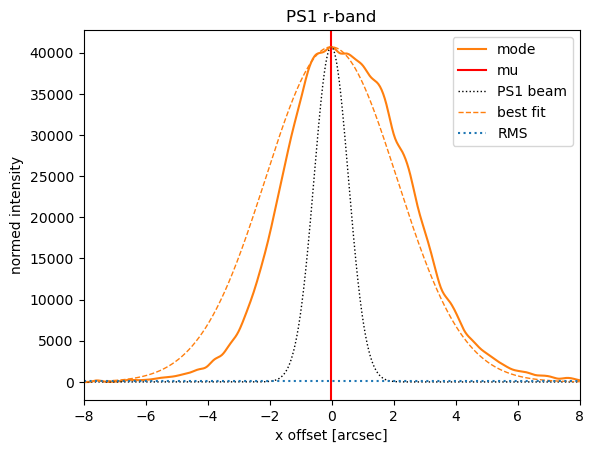

In [34]:
# center all lines to their maximum and "stack" them onto one position
old_grid_rband = np.linspace(0,PS1_rband_rotated.shape[1],PS1_rband_rotated.shape[1])
new_grid_rband = np.linspace(0,PS1_rband_rotated.shape[1],1000)
new_grid_centered_rband = (new_grid_rband-np.max(new_grid_rband)/2.)*(rband_header['CDELT1']*u.deg).to(u.arcsec).value

list_centered_rband = []
for i in range(len(PS1_rband_rotated)):
    model = spl(old_grid_rband, PS1_rband_rotated[i], ext=1)
    list_centered_rband.append(model(new_grid_rband))
    #plt.plot(new_grid_centered_rband, model(new_grid_rband), c='C2', alpha=0.1)
list_centered_rband = np.array(list_centered_rband)   

mean_list_centered_rband = np.mean(list_centered_rband, axis=0)
median_list_centered_rband = np.median(list_centered_rband, axis=0)
std_list_centered_rband = np.std(list_centered_rband, axis=0)

plt.plot(new_grid_centered_rband, list_centered_rband[idx_center_rband], label='mode', c='C1')


### overplot Gaussian
x_axis = np.arange(-10, 10, 0.001)

x_axis = np.arange(-15, 15, 0.001)
mu_rband = new_grid_centered_rband[np.where(list_centered_rband[idx_center_rband]==np.max(list_centered_rband[idx_center_rband]))]
plt.axvline(mu_rband, ls='-', c='red', label='mu')

# overplot Gaussian for the PS1 beam 
FWHM_rband = 1.31 # arcsec, median PSF in r-band, cf. Table 11 in Chambers+2016 https://arxiv.org/pdf/1612.05560.pdf
plt.plot(x_axis, norm.pdf(x_axis,mu_rband,FWHM_rband/2.355)/np.max(norm.pdf(x_axis,0.,FWHM_rband/2.355))*np.max(list_centered_rband[idx_center_rband]), c='black', ls=':', lw=1, label='PS1 beam')

# overplot Gaussian with width of profile
FWHM = 5.0 # arcsec
plt.plot(x_axis, norm.pdf(x_axis,mu_rband,FWHM/2.355)/np.max(norm.pdf(x_axis,0.,FWHM/2.355))*np.max(list_centered_rband[idx_center_rband]), c='C1', ls='--', lw=1, label='best fit')

rms_rband = 117.017
plt.axhline(rms_rband, ls=':', label='RMS')
idx_noise = np.where(list_centered_rband[idx_center_rband] <= rms_rband)

noise_left = new_grid_centered_rband[idx_noise][np.where(new_grid_centered_rband[idx_noise] < mu_rband)]
noise_right = new_grid_centered_rband[idx_noise][np.where(new_grid_centered_rband[idx_noise] >= mu_rband)]
print(np.max(noise_left), np.min(noise_right), (np.abs(np.max(noise_left))+np.min(noise_right))/2)

plt.xlabel('x offset [arcsec]')
plt.ylabel('normed intensity')
plt.xlim(-8,8)
plt.legend()
plt.title('PS1 r-band')

FWHM, mean, sigma, amplitude:  4.554271414245906 0.46033319600231004 1.9340209982737977 41993.71931048932
deconvolved FWHM, sigma =  4.361798724679693 1.8521438321357508
2*sigma, 3*sigma:  3.7042876642715017 5.556431496407253


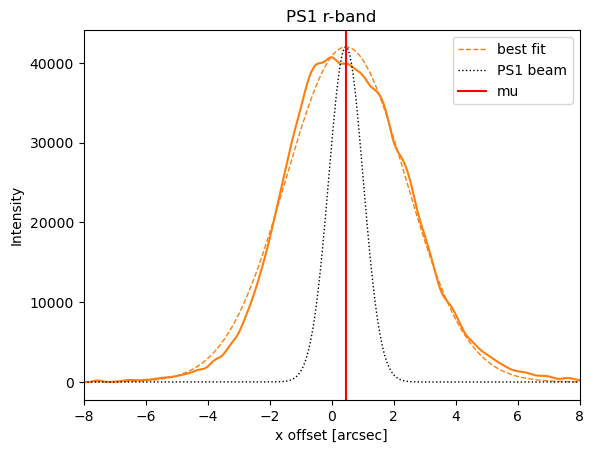

In [35]:
fitter = modeling.fitting.LevMarLSQFitter()
model = modeling.models.Gaussian1D()   # depending on the data you need to give some initial values
fitted_model_rband = fitter(model, new_grid_centered_rband, list_centered_rband[idx_center_rband])

print('FWHM, mean, sigma, amplitude: ', fitted_model_rband.fwhm, fitted_model_rband.mean[0], fitted_model_rband.stddev[0], fitted_model_rband.amplitude[0])

plt.plot(new_grid_centered_rband, list_centered_rband[idx_center_rband], c='C1')
plt.plot(new_grid_centered_rband, fitted_model_rband(new_grid_centered_rband), c='C1', ls='--', lw=1, label='best fit')

# overplot Gaussian for the PS1 beam 
FWHM_rband = 1.31 # arcsec, median PSF in r-band, cf. Table 11 in Chambers+2016 https://arxiv.org/pdf/1612.05560.pdf
plt.plot(x_axis, norm.pdf(x_axis,fitted_model_rband.mean[0],FWHM_rband/2.355)/np.max(norm.pdf(x_axis,fitted_model_rband.mean[0],FWHM_rband/2.355))*np.max(fitted_model_rband(new_grid_centered_rband)), c='black', ls=':', lw=1, label='PS1 beam')

plt.axvline(fitted_model_rband.mean[0], ls='-', c='red', label='mu')

plt.xlabel('x offset [arcsec]')
plt.ylabel('Intensity')
plt.xlim(-8,8)
plt.legend()
plt.title('PS1 r-band')

FWHM_deconv = deconvolve_FWHM(FWHM_rband, fitted_model_rband.fwhm)
sigma_deconv = FWHM_deconv/2.355
print('deconvolved FWHM, sigma = ', FWHM_deconv, sigma_deconv)
print('2*sigma, 3*sigma: ', 2*sigma_deconv, 3*sigma_deconv)

### PS1 i-band

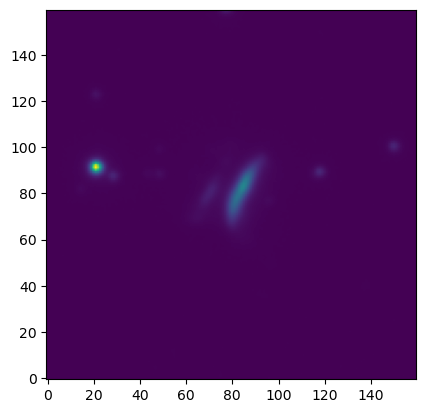

In [36]:
### load in data
iband_file = PS1_data_path+'cutout_rings.v3.skycell.2537.088.stk.i.unconv.fits'
iband = fits.open(iband_file)
wcs = WCS(iband[0].header)
iband_data = iband[0].data
iband_header = iband[0].header
iband = np.array(iband_data)

plt.imshow(iband_data, origin='lower')

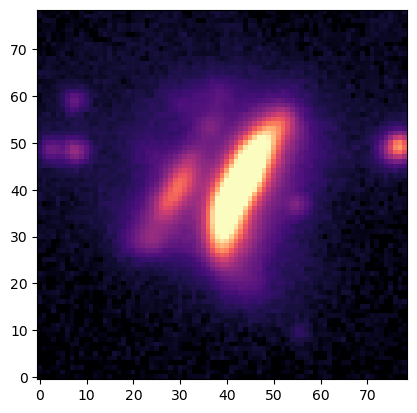

In [37]:
### convert IRAS sky position into PS1 pixel coordinates
x, y = wcs.world_to_pixel(DraChi_coord)

### get PS1 pixel scale
x_pixscale = iband_header['CDELT1']*60.*60.*u.arcsec # arcsec per pixel
y_pixscale = iband_header['CDELT2']*60.*60.*u.arcsec # arcsec per pixel

len_box_x = 20.*u.arcsec / x_pixscale
len_box_y = 20.*u.arcsec / y_pixscale

position = (int(x),int(y)) # x,y pixels
size = (int(len_box_y),int(len_box_x)) # ny, nx pixels

cutout_iband = Cutout2D(np.array(iband_data), position, size)

norm = ImageNormalize(stretch=SqrtStretch(), vmin=0, vmax=5e4)  
plt.imshow(cutout_iband.data, origin='lower', cmap='magma', interpolation='nearest', norm=norm)

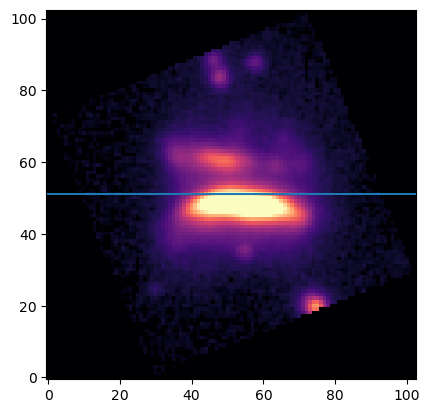

In [38]:
### now rotate the cube

PA_disk = 338.
PA = PA_disk+90.

PS1_iband_rotated = rotate(cutout_iband.data, PA)

norm = ImageNormalize(stretch=SqrtStretch(), vmin=0, vmax=5e4)  
plt.imshow(PS1_iband_rotated, origin='lower', cmap='magma', interpolation='nearest', norm=norm)

idx_center_iband = int(len(PS1_iband_rotated)/2.)
plt.axhline(idx_center_iband)

-7.41053571497708 8.467342547373809 7.938939131175444


Text(0.5, 1.0, 'PS1 i-band')

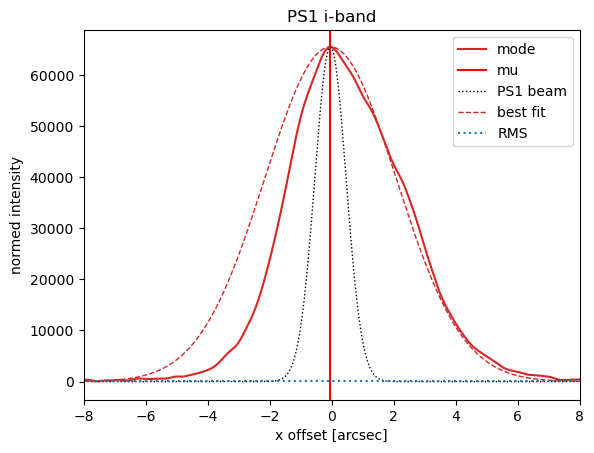

In [47]:
# center all lines to their maximum and "stack" them onto one position
old_grid_iband = np.linspace(0,PS1_iband_rotated.shape[1],PS1_iband_rotated.shape[1])
new_grid_iband = np.linspace(0,PS1_iband_rotated.shape[1],1000)
new_grid_centered_iband = (new_grid_iband-np.max(new_grid_iband)/2.)*(iband_header['CDELT1']*u.deg).to(u.arcsec).value

list_centered_iband = []
for i in range(len(PS1_iband_rotated)):
    model = spl(old_grid_iband, PS1_iband_rotated[i], ext=1)
    list_centered_iband.append(model(new_grid_iband))
    #plt.plot(new_grid_centered_iband, model(new_grid_iband), c='C2', alpha=0.1)
list_centered_iband = np.array(list_centered_iband)   

mean_list_centered_iband = np.mean(list_centered_iband, axis=0)
median_list_centered_iband = np.median(list_centered_iband, axis=0)
std_list_centered_iband = np.std(list_centered_iband, axis=0)


#plt.plot(new_grid_centered_iband, mean_list_centered_iband, label='mean', ls=':', c='C2')

plt.plot(new_grid_centered_iband, list_centered_iband[idx_center_iband], label='mode', c='C3')


### overplot Gaussian
x_axis = np.arange(-10, 10, 0.001)

x_axis = np.arange(-15, 15, 0.001)
mu_iband = new_grid_centered_iband[np.where(list_centered_iband[idx_center_iband]==np.max(list_centered_iband[idx_center_iband]))]
plt.axvline(mu_iband, ls='-', c='red', label='mu')

# overplot Gaussian for the PS1 beam 
FWHM_iband = 1.19 # arcsec, median PSF in i-band, cf. Table 11 in Chambers+2016 https://arxiv.org/pdf/1612.05560.pdf
plt.plot(x_axis, norm.pdf(x_axis,mu_iband,FWHM_iband/2.355)/np.max(norm.pdf(x_axis,0.,FWHM_iband/2.355))*np.max(list_centered_iband[idx_center_iband]), c='black', ls=':', lw=1, label='PS1 beam')

# overplot Gaussian with width of profile
FWHM = 5.0 # arcsec
plt.plot(x_axis, norm.pdf(x_axis,mu_iband,FWHM/2.355)/np.max(norm.pdf(x_axis,0.,FWHM/2.355))*np.max(list_centered_iband[idx_center_iband]), c='C3', ls='--', lw=1, label='best fit')

rms_iband = 162.716
plt.axhline(rms_iband, ls=':', label='RMS')
idx_noise = np.where(list_centered_iband[idx_center_iband] <= rms_iband)

noise_left = new_grid_centered_iband[idx_noise][np.where(new_grid_centered_iband[idx_noise] < mu_iband)]
noise_right = new_grid_centered_iband[idx_noise][np.where(new_grid_centered_iband[idx_noise] >= mu_iband)]
print(np.max(noise_left), np.min(noise_right), (np.abs(np.max(noise_left))+np.min(noise_right))/2)

plt.xlabel('x offset [arcsec]')
plt.ylabel('normed intensity')
plt.xlim(-8,8)
plt.legend()
plt.title('PS1 i-band')

FWHM, mean, sigma, amplitude:  4.32473090429647 0.42409578362594025 1.8365441186991553 63752.23583489932
deconvolved FWHM, sigma =  4.157787560058471 1.765514887498289
2*sigma, 3*sigma:  3.531029774996578 5.296544662494867


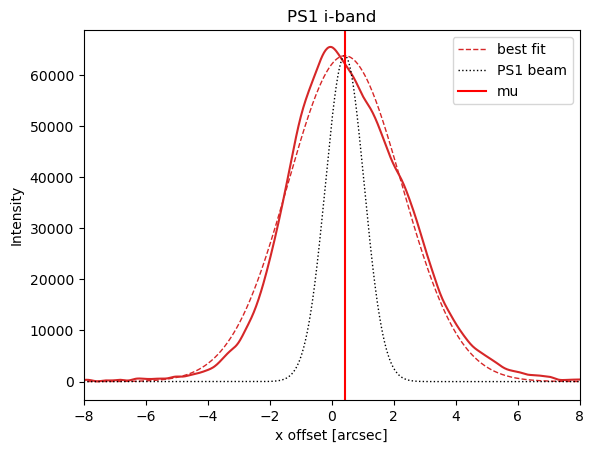

In [40]:
fitter = modeling.fitting.LevMarLSQFitter()
model = modeling.models.Gaussian1D()   # depending on the data you need to give some initial values
fitted_model_iband = fitter(model, new_grid_centered_iband, list_centered_iband[idx_center_iband])

print('FWHM, mean, sigma, amplitude: ', fitted_model_iband.fwhm, fitted_model_iband.mean[0], fitted_model_iband.stddev[0], fitted_model_iband.amplitude[0])


plt.plot(new_grid_centered_iband, list_centered_iband[idx_center_iband], c='C3')
plt.plot(new_grid_centered_iband, fitted_model_iband(new_grid_centered_iband), c='C3', ls='--', lw=1, label='best fit')

# overplot Gaussian for the PS1 beam 
FWHM_iband = 1.19 # arcsec, median PSF in i-band, cf. Table 11 in Chambers+2016 https://arxiv.org/pdf/1612.05560.pdf
plt.plot(x_axis, norm.pdf(x_axis,fitted_model_iband.mean[0],FWHM_gband/2.355)/np.max(norm.pdf(x_axis,fitted_model_iband.mean[0],FWHM_gband/2.355))*np.max(fitted_model_iband(new_grid_centered_iband)), c='black', ls=':', lw=1, label='PS1 beam')

plt.axvline(fitted_model_iband.mean[0], ls='-', c='red', label='mu')

plt.xlabel('x offset [arcsec]')
plt.ylabel('Intensity')
plt.xlim(-8,8)
plt.legend()
plt.title('PS1 i-band')

FWHM_deconv = deconvolve_FWHM(FWHM_iband, fitted_model_iband.fwhm)
sigma_deconv = FWHM_deconv/2.355
print('deconvolved FWHM, sigma = ', FWHM_deconv, sigma_deconv)
print('2*sigma, 3*sigma: ', 2*sigma_deconv, 3*sigma_deconv)

#### continuum

Set OBSGEO-B to    19.947177 from OBSGEO-[XYZ].
Set OBSGEO-H to     6578.484 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


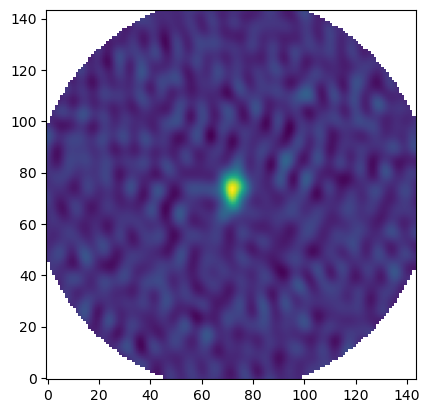

In [49]:
### there are too many dimensions in the fits file header of the continuum file
### therefore I first copy the original into a new one called *_modified_header.fits 
### and then I modify the fits header by hand
! cp /Users/kristina/Hamburgers/Draculas_Chivito/SMA/data/DraChi.CONT.fits /Users/kristina/Hamburgers/Draculas_Chivito/SMA/data/DraChi.CONT_modified_header.fits

cont_comp = fits.open(SMA_data_path+'DraChi.CONT_modified_header.fits')  # open a FITS file

del cont_comp[0].header['NAXIS3']
del cont_comp[0].header['NAXIS4']
cont_comp[0].header['NAXIS'] = 2
del cont_comp[0].header['CTYPE3']
del cont_comp[0].header['CRVAL3']
del cont_comp[0].header['CDELT3']
del cont_comp[0].header['CRPIX3']
del cont_comp[0].header['CUNIT3']

del cont_comp[0].header['CTYPE4']
del cont_comp[0].header['CRVAL4']
del cont_comp[0].header['CDELT4']
del cont_comp[0].header['CRPIX4']
del cont_comp[0].header['CUNIT4']  

del cont_comp[0].header['PC3_1']  
del cont_comp[0].header['PC4_1']  
del cont_comp[0].header['PC3_2']  
del cont_comp[0].header['PC4_2']  
del cont_comp[0].header['PC3_3']  
del cont_comp[0].header['PC4_3']  
del cont_comp[0].header['PC3_4']  
del cont_comp[0].header['PC4_4']  

del cont_comp[0].header['PC1_3']  
del cont_comp[0].header['PC1_4']  
del cont_comp[0].header['PC2_3']  
del cont_comp[0].header['PC2_4']  


wcs = WCS(cont_comp[0].header)

plt.imshow(cont_comp[0].data[0][0], origin='lower')

max_cont_comp = 0.016 # Jy/beam from CASAviewer
rms_cont_comp = 2.41e2 # Jy/beam from CASAviewer

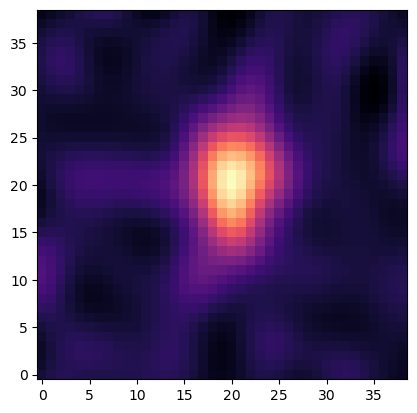

In [50]:
### convert IRAS sky position into PS1 pixel coordinates
x, y = wcs.world_to_pixel(DraChi_coord)

### get PS1 pixel scale
x_pixscale = -cont_comp[0].header['CDELT1']*60.*60.*u.arcsec # arcsec per pixel
y_pixscale = cont_comp[0].header['CDELT2']*60.*60.*u.arcsec # arcsec per pixel

len_box_x = 20.*u.arcsec / x_pixscale
len_box_y = 20.*u.arcsec / y_pixscale

position = (int(x),int(y)) # x,y pixels
size = (int(len_box_y),int(len_box_x)) # ny, nx pixels

cutout_cont = Cutout2D(np.array(cont_comp[0].data[0][0]), position, size)

plt.imshow(cutout_cont.data, origin='lower', cmap='magma', interpolation='nearest')

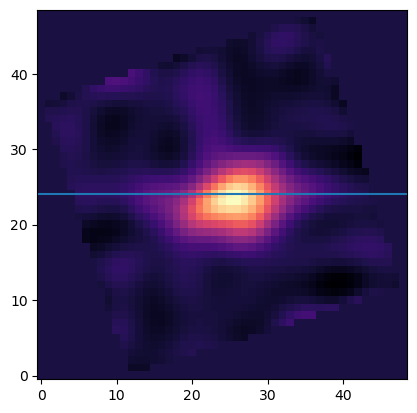

In [51]:
### now rotate the cube
PA_disk = 342.
PA = PA_disk+90.

cont_rotated = rotate(cutout_cont.data, PA)

plt.imshow(cont_rotated, origin='lower', cmap='magma', interpolation='nearest')

idx_center_cont = int(len(cont_rotated)/2.)
plt.axhline(idx_center_cont)

-8.375125125125793 9.748498498499279 9.061811811812536


Text(0.5, 1.0, '1.3mm continuum')

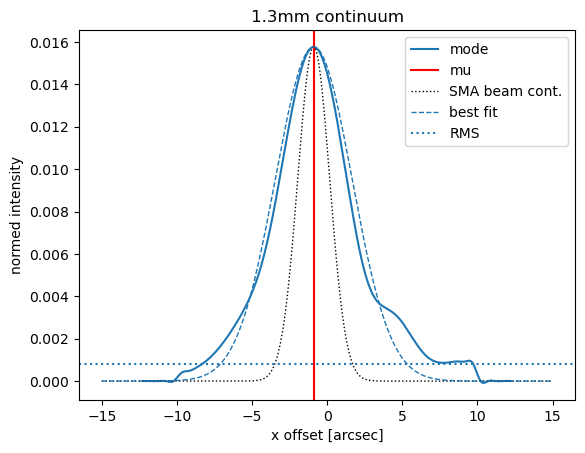

In [52]:
# center all lines to their maximum and "stack" them onto one position
old_grid_cont = np.linspace(0,cont_rotated.shape[1],cont_rotated.shape[1])
new_grid_cont = np.linspace(0,cont_rotated.shape[1],1000)
new_grid_centered_cont = (new_grid_cont-np.max(new_grid_cont)/2.)*(cont_comp[0].header['CDELT1']*u.deg).to(u.arcsec).value

list_centered_cont = []
for i in range(len(cont_rotated)):
    model = spl(old_grid_cont, cont_rotated[i], ext=1)
    list_centered_cont.append(model(new_grid_cont))
    #plt.plot(new_grid_centered_cont, model(new_grid_cont), c='C2', alpha=0.1)
list_centered_cont = np.array(list_centered_cont)   

mean_list_centered_cont = np.mean(list_centered_cont, axis=0)
median_list_centered_cont = np.median(list_centered_cont, axis=0)
std_list_centered_cont = np.std(list_centered_cont, axis=0)


#plt.plot(new_grid_centered_cont, mean_list_centered_cont, label='mean', c='C2')

plt.plot(new_grid_centered_cont, list_centered_cont[idx_center_cont], label='mode', c='C0')

### overplot Gaussian
x_axis = np.arange(-15, 15, 0.001)
mu_cont = new_grid_centered_cont[np.where(list_centered_cont[idx_center_cont]==np.max(list_centered_cont[idx_center_cont]))]
plt.axvline(mu_cont, ls='-', c='red', label='mu')

# overplot Gaussian for the PS1 beam 
FWHM_cont = 2.5 # arcsec
plt.plot(x_axis, norm.pdf(x_axis,mu_cont,FWHM_cont/2.355)/np.max(norm.pdf(x_axis,0.,FWHM_cont/2.355))*np.max(list_centered_cont[idx_center_cont]), c='black', ls=':', lw=1, label='SMA beam cont.')

# overplot Gaussian with width of profile
FWHM = 6 # arcsec
plt.plot(x_axis, norm.pdf(x_axis,mu_cont,FWHM/2.355)/np.max(norm.pdf(x_axis,0.,FWHM/2.355))*np.max(list_centered_cont[idx_center_cont]), c='C0', ls='--', lw=1, label='best fit')


rms_cont = 7.86e-4
plt.axhline(rms_cont, ls=':', label='RMS')
idx_noise = np.where(list_centered_cont[idx_center_cont] <= rms_cont)

noise_left = new_grid_centered_cont[idx_noise][np.where(new_grid_centered_cont[idx_noise] < mu_cont)]
noise_right = new_grid_centered_cont[idx_noise][np.where(new_grid_centered_cont[idx_noise] >= mu_cont)]
print(np.max(noise_left), np.min(noise_right), (np.abs(np.max(noise_left))+np.min(noise_right))/2)



plt.xlabel('x offset [arcsec]')
plt.ylabel('normed intensity')
#plt.xlim(-8,8)
plt.legend()
plt.title('1.3mm continuum')

FWHM, mean, sigma, amplitude:  6.1127725865298626 -0.9141471103761756 2.595855508971397 0.014899786384357653
deconvolved FWHM, sigma =  5.5781707301436185 2.3686499915684154
2*sigma, 3*sigma:  4.737299983136831 7.105949974705246


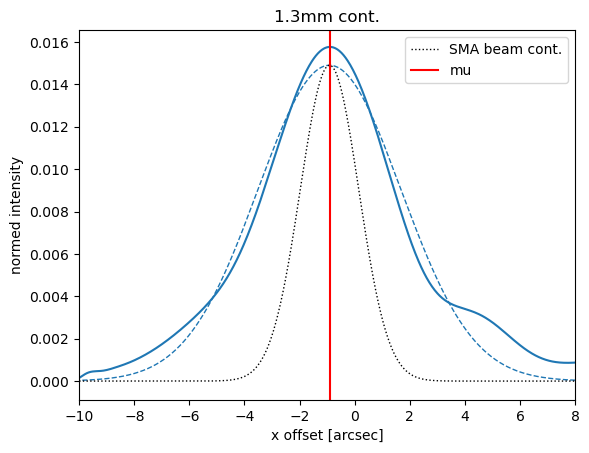

In [53]:
from astropy import modeling

fitter = modeling.fitting.LevMarLSQFitter()
model = modeling.models.Gaussian1D()   # depending on the data you need to give some initial values
fitted_model_cont = fitter(model, new_grid_centered_cont, list_centered_cont[idx_center_cont])

print('FWHM, mean, sigma, amplitude: ', fitted_model_cont.fwhm, fitted_model_cont.mean[0], fitted_model_cont.stddev[0], fitted_model_cont.amplitude[0])


plt.plot(new_grid_centered_cont, list_centered_cont[idx_center_cont], c='C0')
plt.plot(new_grid_centered_cont, fitted_model_cont(new_grid_centered_cont), c='C0', ls='--', lw=1)

# overplot Gaussian for the PS1 beam 
FWHM_cont = 2.5 # arcsec
plt.plot(x_axis, norm.pdf(x_axis,fitted_model_cont.mean[0],FWHM_cont/2.355)/np.max(norm.pdf(x_axis,fitted_model_cont.mean[0],FWHM_cont/2.355))*np.max(fitted_model_cont(new_grid_centered_cont)), c='black', ls=':', lw=1, label='SMA beam cont.')

plt.axvline(fitted_model_cont.mean[0], ls='-', c='red', label='mu')


plt.xlabel('x offset [arcsec]')
plt.ylabel('normed intensity')
plt.xlim(-10,8)
plt.legend()
plt.title('1.3mm cont.')

FWHM_deconv = deconvolve_FWHM(FWHM_cont, fitted_model_cont.fwhm)
sigma_deconv = FWHM_deconv/2.355
print('deconvolved FWHM, sigma = ', FWHM_deconv, sigma_deconv)
print('2*sigma, 3*sigma: ', 2*sigma_deconv, 3*sigma_deconv)

### 12CO

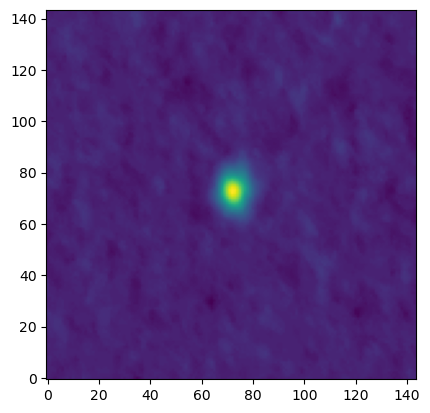

In [54]:
mom0_12CO_comp = fits.open(SMA_data_path+'DraChi.briggs0.12CO.velcor.fixVel.lsrk.im.image_M0.fits')
wcs = WCS(mom0_12CO_comp[0].header)

plt.imshow(mom0_12CO_comp[0].data, origin='lower')

rms_12CO_comp = 1.7e2 # Jy/beam m/s from mom0 map
max_12CO_comp = 1.04e4 # Jy/beam m/s from mom0 map

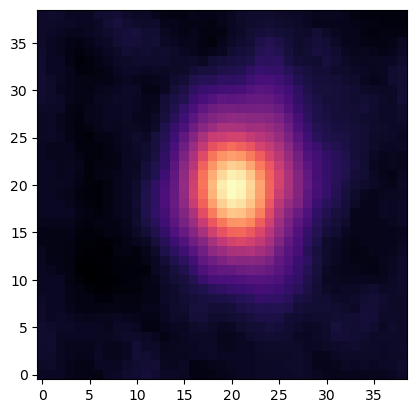

In [55]:
### convert IRAS sky position into PS1 pixel coordinates
x, y = wcs.world_to_pixel(DraChi_coord)

### get PS1 pixel scale
x_pixscale = -mom0_12CO_comp[0].header['CDELT1']*60.*60.*u.arcsec # arcsec per pixel
y_pixscale = mom0_12CO_comp[0].header['CDELT2']*60.*60.*u.arcsec # arcsec per pixel

len_box_x = 20.*u.arcsec / x_pixscale
len_box_y = 20.*u.arcsec / y_pixscale

position = (int(x),int(y)) # x,y pixels
size = (int(len_box_y),int(len_box_x)) # ny, nx pixels

cutout_12CO = Cutout2D(np.array(mom0_12CO_comp[0].data), position, size)

plt.imshow(cutout_12CO.data, origin='lower', cmap='magma', interpolation='nearest')

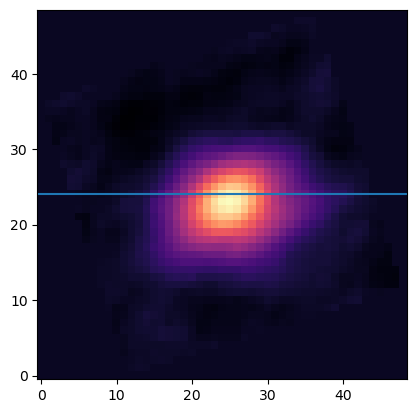

In [56]:
### now rotate the cube

PA_disk = 342.
PA = PA_disk+90.

mom0_12CO_rotated = rotate(cutout_12CO.data, PA)

plt.imshow(mom0_12CO_rotated, origin='lower', cmap='magma', interpolation='nearest')

idx_center_12CO = int(len(mom0_12CO_rotated)/2.)
plt.axhline(idx_center_12CO)

-9.895645645646434 6.830080080080626 8.36286286286353


Text(0.5, 1.0, '12CO')

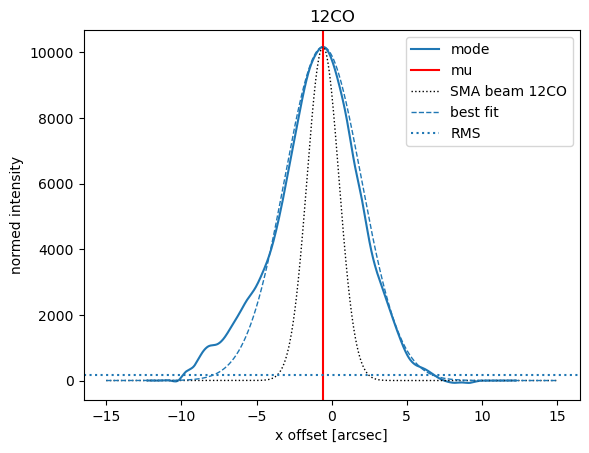

In [57]:
# center all lines to their maximum and "stack" them onto one position
old_grid_12CO = np.linspace(0,mom0_12CO_rotated.shape[1],mom0_12CO_rotated.shape[1])
new_grid_12CO = np.linspace(0,mom0_12CO_rotated.shape[1],1000)
new_grid_centered_12CO = (new_grid_12CO-np.max(new_grid_12CO)/2.)*(mom0_12CO_comp[0].header['CDELT1']*u.deg).to(u.arcsec).value

list_centered_12CO = []
for i in range(len(mom0_12CO_rotated)):
    model = spl(old_grid_12CO, mom0_12CO_rotated[i], ext=1)
    list_centered_12CO.append(model(new_grid_12CO))
    #plt.plot(new_grid_centered_12CO, model(new_grid_12CO), c='C2', alpha=0.1)
list_centered_12CO = np.array(list_centered_12CO)   

mean_list_centered_12CO = np.mean(list_centered_12CO, axis=0)
median_list_centered_12CO = np.median(list_centered_12CO, axis=0)
std_list_centered_12CO = np.std(list_centered_12CO, axis=0)


#plt.plot(new_grid_centered_12CO, mean_list_centered_12CO, label='mean', c='C2')

plt.plot(new_grid_centered_12CO, list_centered_12CO[idx_center_12CO], label='mode', c='C0')

### overplot Gaussian
x_axis = np.arange(-15, 15, 0.001)
mu_12CO = new_grid_centered_12CO[np.where(list_centered_12CO[idx_center_12CO]==np.max(list_centered_12CO[idx_center_12CO]))]
plt.axvline(mu_12CO, ls='-', c='red', label='mu')

# overplot Gaussian for the PS1 beam 
FWHM_12CO = 2.5 # arcsec
plt.plot(x_axis, norm.pdf(x_axis,mu_12CO,FWHM_12CO/2.355)/np.max(norm.pdf(x_axis,0.,FWHM_12CO/2.355))*np.max(list_centered_12CO[idx_center_12CO]), c='black', ls=':', lw=1, label='SMA beam 12CO')

# overplot Gaussian with width of profile
FWHM = 6 # arcsec
plt.plot(x_axis, norm.pdf(x_axis,mu_12CO,FWHM/2.355)/np.max(norm.pdf(x_axis,0.,FWHM/2.355))*np.max(list_centered_12CO[idx_center_12CO]), c='C0', ls='--', lw=1, label='best fit')

rms_12CO = 1.7e2
plt.axhline(rms_12CO, ls=':', label='RMS')
idx_noise = np.where(list_centered_12CO[idx_center_12CO] <= rms_12CO)

noise_left = new_grid_centered_12CO[idx_noise][np.where(new_grid_centered_12CO[idx_noise] < mu_12CO)]
noise_right = new_grid_centered_12CO[idx_noise][np.where(new_grid_centered_12CO[idx_noise] >= mu_12CO)]
print(np.max(noise_left), np.min(noise_right), (np.abs(np.max(noise_left))+np.min(noise_right))/2)


plt.xlabel('x offset [arcsec]')
plt.ylabel('normed intensity')
#plt.xlim(-8,8)
plt.legend()
plt.title('12CO')

FWHM, mean, sigma, amplitude:  6.247085758616179 -0.7247011124650274 2.652893061530769 9707.901748446116
deconvolved FWHM, sigma =  5.725039779381894 2.431014768315029
2*sigma, 3*sigma:  4.862029536630058 7.293044304945088


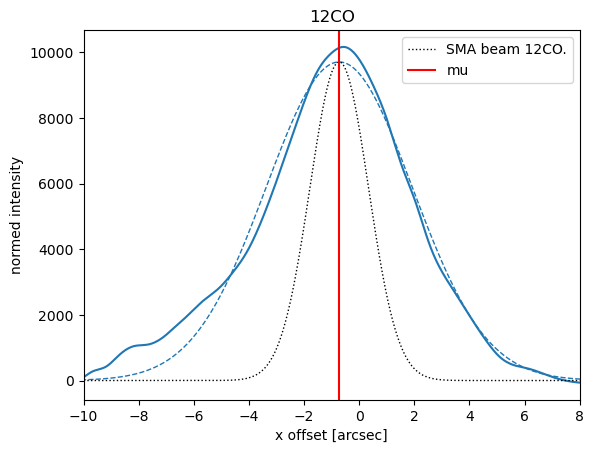

In [58]:
from astropy import modeling

fitter = modeling.fitting.LevMarLSQFitter()
model = modeling.models.Gaussian1D()   # depending on the data you need to give some initial values
fitted_model_12CO = fitter(model, new_grid_centered_12CO, list_centered_12CO[idx_center_12CO])

print('FWHM, mean, sigma, amplitude: ', fitted_model_12CO.fwhm, fitted_model_12CO.mean[0], fitted_model_12CO.stddev[0], fitted_model_12CO.amplitude[0])

plt.plot(new_grid_centered_12CO, list_centered_12CO[idx_center_12CO], c='C0')
plt.plot(new_grid_centered_12CO, fitted_model_12CO(new_grid_centered_12CO), c='C0', ls='--', lw=1)

# overplot Gaussian for the PS1 beam 
FWHM_12CO = 2.5 # arcsec
plt.plot(x_axis, norm.pdf(x_axis,fitted_model_12CO.mean[0],FWHM_12CO/2.355)/np.max(norm.pdf(x_axis,fitted_model_12CO.mean[0],FWHM_12CO/2.355))*np.max(fitted_model_12CO(new_grid_centered_12CO)), c='black', ls=':', lw=1, label='SMA beam 12CO.')

plt.axvline(fitted_model_12CO.mean[0], ls='-', c='red', label='mu')


plt.xlabel('x offset [arcsec]')
plt.ylabel('normed intensity')
plt.xlim(-10,8)
plt.legend()
plt.title('12CO')

FWHM_deconv = deconvolve_FWHM(FWHM_12CO, fitted_model_12CO.fwhm)
sigma_deconv = FWHM_deconv/2.355
print('deconvolved FWHM, sigma = ', FWHM_deconv, sigma_deconv)
print('2*sigma, 3*sigma: ', 2*sigma_deconv, 3*sigma_deconv)

#### 13CO

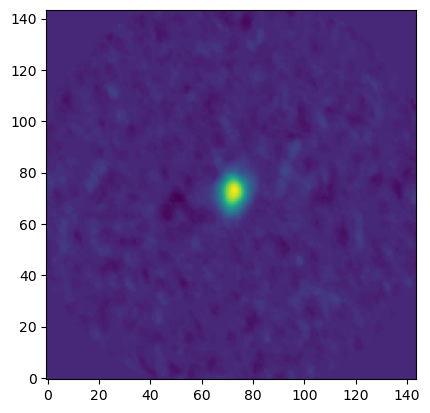

In [59]:
mom0_13CO_comp = fits.open(SMA_data_path+'DraChi.briggs0.13CO.velcor.fixVel.lsrk.im.image_M0.fits')
wcs = WCS(mom0_13CO_comp[0].header)

plt.imshow(mom0_13CO_comp[0].data, origin='lower')


rms_13CO_comp = 1.26e2 # Jy/beam m/s; value taken from CASAviewer
max_13CO_comp = 6.4e3 # mJy/beam m/s from mom0 map

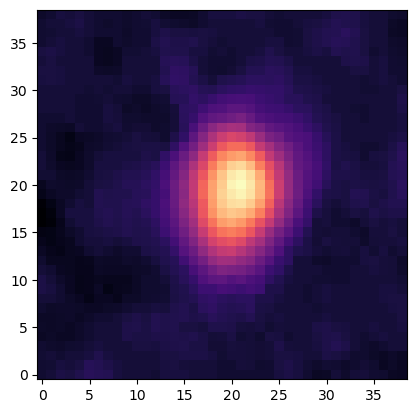

In [60]:
### convert IRAS sky position into PS1 pixel coordinates
x, y = wcs.world_to_pixel(DraChi_coord)

### get PS1 pixel scale
x_pixscale = -mom0_13CO_comp[0].header['CDELT1']*60.*60.*u.arcsec # arcsec per pixel
y_pixscale = mom0_13CO_comp[0].header['CDELT2']*60.*60.*u.arcsec # arcsec per pixel

len_box_x = 20.*u.arcsec / x_pixscale
len_box_y = 20.*u.arcsec / y_pixscale

position = (int(x),int(y)) # x,y pixels
size = (int(len_box_y),int(len_box_x)) # ny, nx pixels

cutout_13CO = Cutout2D(np.array(mom0_13CO_comp[0].data), position, size)

plt.imshow(cutout_13CO.data, origin='lower', cmap='magma', interpolation='nearest')

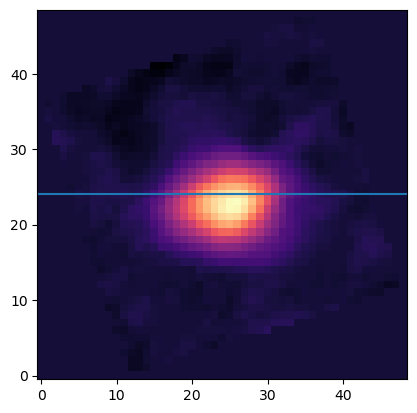

In [61]:
### now rotate the cube

PA_disk = 342.
PA = PA_disk+90.

mom0_13CO_rotated = rotate(cutout_13CO.data, PA)

plt.imshow(mom0_13CO_rotated, origin='lower', cmap='magma', interpolation='nearest')

idx_center_13CO = int(len(mom0_13CO_rotated)/2.)
plt.axhline(idx_center_13CO)

-8.546796796797478 8.939189189189904 8.742992992993692


Text(0.5, 1.0, '13CO')

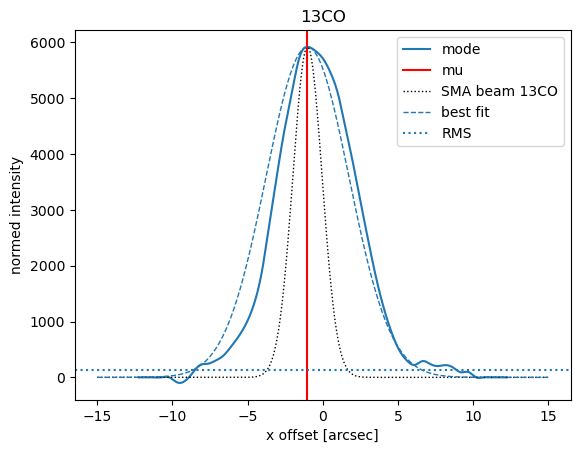

In [62]:
# center all lines to their maximum and "stack" them onto one position
old_grid_13CO = np.linspace(0,mom0_13CO_rotated.shape[1],mom0_13CO_rotated.shape[1])
new_grid_13CO = np.linspace(0,mom0_13CO_rotated.shape[1],1000)
new_grid_centered_13CO = (new_grid_13CO-np.max(new_grid_13CO)/2.)*(mom0_13CO_comp[0].header['CDELT1']*u.deg).to(u.arcsec).value

list_centered_13CO = []
for i in range(len(mom0_13CO_rotated)):
    model = spl(old_grid_13CO, mom0_13CO_rotated[i], ext=1)
    list_centered_13CO.append(model(new_grid_13CO))
    #plt.plot(new_grid_centered_13CO, model(new_grid_13CO), c='C2', alpha=0.1)
list_centered_13CO = np.array(list_centered_13CO)   

mean_list_centered_13CO = np.mean(list_centered_13CO, axis=0)
median_list_centered_13CO = np.median(list_centered_13CO, axis=0)
std_list_centered_13CO = np.std(list_centered_13CO, axis=0)


#plt.plot(new_grid_centered_13CO, mean_list_centered_13CO, label='mean', c='C2')

plt.plot(new_grid_centered_13CO, list_centered_13CO[idx_center_13CO], label='mode', c='C0')

### overplot Gaussian
x_axis = np.arange(-15, 15, 0.001)
mu_13CO = new_grid_centered_13CO[np.where(list_centered_13CO[idx_center_13CO]==np.max(list_centered_13CO[idx_center_13CO]))]
plt.axvline(mu_13CO, ls='-', c='red', label='mu')

# overplot Gaussian for the PS1 beam 
FWHM_13CO = 2.3 # arcsec
plt.plot(x_axis, norm.pdf(x_axis,mu_13CO,FWHM_13CO/2.355)/np.max(norm.pdf(x_axis,0.,FWHM_13CO/2.355))*np.max(list_centered_13CO[idx_center_13CO]), c='black', ls=':', lw=1, label='SMA beam 13CO')

# overplot Gaussian with width of profile
FWHM = 6.5 # arcsec
plt.plot(x_axis, norm.pdf(x_axis,mu_13CO,FWHM/2.355)/np.max(norm.pdf(x_axis,0.,FWHM/2.355))*np.max(list_centered_13CO[idx_center_13CO]), c='C0', ls='--', lw=1, label='best fit')

rms_13CO = 1.26e2
plt.axhline(rms_13CO, ls=':', label='RMS')
idx_noise = np.where(list_centered_13CO[idx_center_13CO] <= rms_13CO)

noise_left = new_grid_centered_13CO[idx_noise][np.where(new_grid_centered_13CO[idx_noise] < mu_13CO)]
noise_right = new_grid_centered_13CO[idx_noise][np.where(new_grid_centered_13CO[idx_noise] >= mu_13CO)]
print(np.max(noise_left), np.min(noise_right), (np.abs(np.max(noise_left))+np.min(noise_right))/2)


plt.xlabel('x offset [arcsec]')
plt.ylabel('normed intensity')
#plt.xlim(-8,8)
plt.legend()
plt.title('13CO')

FWHM, mean, sigma, amplitude:  5.953757645175776 -0.43810616258935753 2.5283280808396236 6022.613288903009
deconvolved FWHM, sigma =  5.491559896558446 2.3318725675407412
2*sigma, 3*sigma:  4.6637451350814825 6.995617702622224


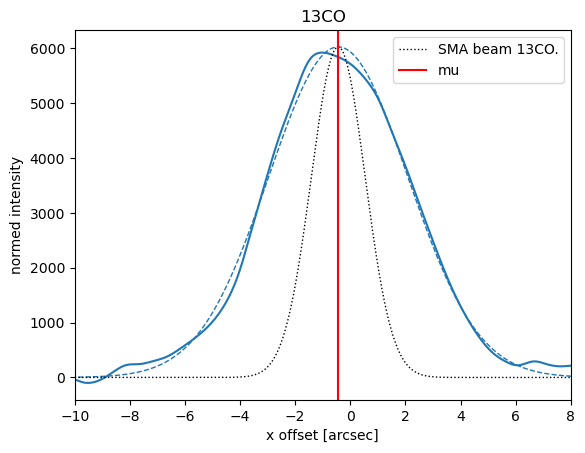

In [63]:
fitter = modeling.fitting.LevMarLSQFitter()
model = modeling.models.Gaussian1D()   # depending on the data you need to give some initial values
fitted_model_13CO = fitter(model, new_grid_centered_13CO, list_centered_13CO[idx_center_13CO])

print('FWHM, mean, sigma, amplitude: ', fitted_model_13CO.fwhm, fitted_model_13CO.mean[0], fitted_model_13CO.stddev[0], fitted_model_13CO.amplitude[0])

plt.plot(new_grid_centered_13CO, list_centered_13CO[idx_center_13CO], c='C0')
plt.plot(new_grid_centered_13CO, fitted_model_13CO(new_grid_centered_13CO), c='C0', ls='--', lw=1)

# overplot Gaussian for the PS1 beam 
FWHM_13CO = 2.3 # arcsec
plt.plot(x_axis, norm.pdf(x_axis,fitted_model_13CO.mean[0],FWHM_13CO/2.355)/np.max(norm.pdf(x_axis,fitted_model_13CO.mean[0],FWHM_13CO/2.355))*np.max(fitted_model_13CO(new_grid_centered_13CO)), c='black', ls=':', lw=1, label='SMA beam 13CO.')

plt.axvline(fitted_model_13CO.mean[0], ls='-', c='red', label='mu')


plt.xlabel('x offset [arcsec]')
plt.ylabel('normed intensity')
plt.xlim(-10,8)
plt.legend()
plt.title('13CO')

FWHM_deconv = deconvolve_FWHM(FWHM_13CO, fitted_model_13CO.fwhm)
sigma_deconv = FWHM_deconv/2.355
print('deconvolved FWHM, sigma = ', FWHM_deconv, sigma_deconv)
print('2*sigma, 3*sigma: ', 2*sigma_deconv, 3*sigma_deconv)

### C18O

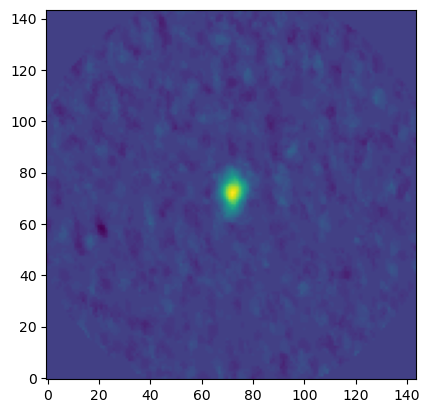

In [64]:
mom0_C18O_comp = fits.open(SMA_data_path+'DraChi.briggs0.C18O.velcor.fixVel.lsrk.im.image_M0.fits')
wcs = WCS(mom0_C18O_comp[0].header)

plt.imshow(mom0_C18O_comp[0].data, origin='lower')

rms_C18O_comp = 1.02e2 # Jy/beam m/s; value taken from CASAviewer
max_C18O_comp = 3.81e3 # Jy/beam m/s; value taken from CASAviewer

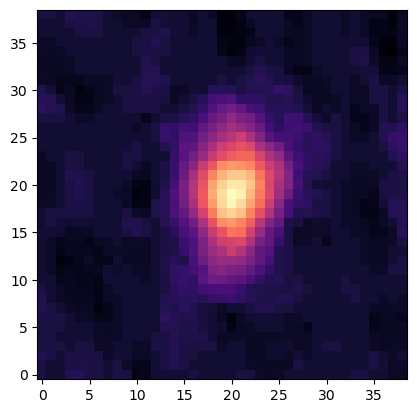

In [65]:
### convert IRAS sky position into PS1 pixel coordinates
x, y = wcs.world_to_pixel(DraChi_coord)

### get PS1 pixel scale
x_pixscale = -mom0_C18O_comp[0].header['CDELT1']*60.*60.*u.arcsec # arcsec per pixel
y_pixscale = mom0_C18O_comp[0].header['CDELT2']*60.*60.*u.arcsec # arcsec per pixel

len_box_x = 20.*u.arcsec / x_pixscale
len_box_y = 20.*u.arcsec / y_pixscale

position = (int(x),int(y)) # x,y pixels
size = (int(len_box_y),int(len_box_x)) # ny, nx pixels

cutout_C18O = Cutout2D(np.array(mom0_C18O_comp[0].data), position, size)

plt.imshow(cutout_C18O.data, origin='lower', cmap='magma', interpolation='nearest')

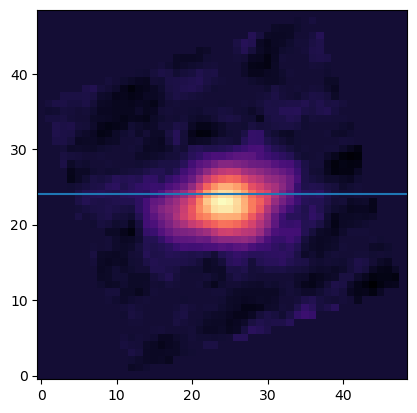

In [66]:
### now rotate the cube

PA_disk = 342.
PA = PA_disk+90.

mom0_C18O_rotated = rotate(cutout_C18O.data, PA)

plt.imshow(mom0_C18O_rotated, origin='lower', cmap='magma', interpolation='nearest')

idx_center_C18O = int(len(mom0_C18O_rotated)/2.)
plt.axhline(idx_center_C18O)

-7.271521521522102 9.723973973974752 8.497747747748427


Text(0.5, 1.0, 'C18O')

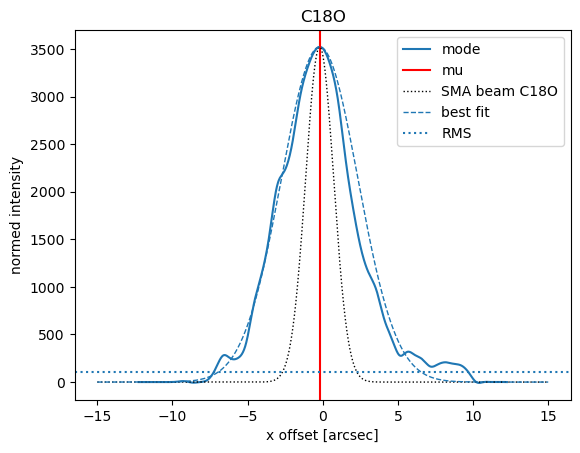

In [67]:
# center all lines to their maximum and "stack" them onto one position
old_grid_C18O = np.linspace(0,mom0_C18O_rotated.shape[1],mom0_C18O_rotated.shape[1])
new_grid_C18O = np.linspace(0,mom0_C18O_rotated.shape[1],1000)
new_grid_centered_C18O = (new_grid_C18O-np.max(new_grid_C18O)/2.)*(mom0_C18O_comp[0].header['CDELT1']*u.deg).to(u.arcsec).value

list_centered_C18O = []
for i in range(len(mom0_C18O_rotated)):
    model = spl(old_grid_C18O, mom0_C18O_rotated[i], ext=1)
    list_centered_C18O.append(model(new_grid_C18O))
    #plt.plot(new_grid_centered_C18O, model(new_grid_C18O), c='C2', alpha=0.1)
list_centered_C18O = np.array(list_centered_C18O)   

mean_list_centered_C18O = np.mean(list_centered_C18O, axis=0)
median_list_centered_C18O = np.median(list_centered_C18O, axis=0)
std_list_centered_C18O = np.std(list_centered_C18O, axis=0)


#plt.plot(new_grid_centered_C18O, mean_list_centered_C18O, label='mean', c='C2')

plt.plot(new_grid_centered_C18O, list_centered_C18O[idx_center_C18O], label='mode', c='C0')

### overplot Gaussian
x_axis = np.arange(-15, 15, 0.001)
mu_C18O = new_grid_centered_C18O[np.where(list_centered_C18O[idx_center_C18O]==np.max(list_centered_C18O[idx_center_C18O]))]
plt.axvline(mu_C18O, ls='-', c='red', label='mu')

# overplot Gaussian for the PS1 beam 
FWHM_C18O = 2.2 # arcsec
plt.plot(x_axis, norm.pdf(x_axis,mu_C18O,FWHM_C18O/2.355)/np.max(norm.pdf(x_axis,0.,FWHM_C18O/2.355))*np.max(list_centered_C18O[idx_center_C18O]), c='black', ls=':', lw=1, label='SMA beam C18O')

# overplot Gaussian with width of profile
FWHM = 6. # arcsec
plt.plot(x_axis, norm.pdf(x_axis,mu_C18O,FWHM/2.355)/np.max(norm.pdf(x_axis,0.,FWHM/2.355))*np.max(list_centered_C18O[idx_center_C18O]), c='C0', ls='--', lw=1, label='best fit')

rms_C18O = 1.02e2
plt.axhline(rms_C18O, ls=':', label='RMS')
idx_noise = np.where(list_centered_C18O[idx_center_C18O] <= rms_C18O)

noise_left = new_grid_centered_C18O[idx_noise][np.where(new_grid_centered_C18O[idx_noise] < mu_C18O)]
noise_right = new_grid_centered_C18O[idx_noise][np.where(new_grid_centered_C18O[idx_noise] >= mu_C18O)]
print(np.max(noise_left), np.min(noise_right), (np.abs(np.max(noise_left))+np.min(noise_right))/2)


plt.xlabel('x offset [arcsec]')
plt.ylabel('normed intensity')
#plt.xlim(-8,8)
plt.legend()
plt.title('C18O')

FWHM, mean, sigma, amplitude:  5.685291369426919 -0.42943265425073657 2.414320950521804 3408.5508543649303
deconvolved FWHM, sigma =  5.24237903582717 2.2260632848523016
2*sigma, 3*sigma:  4.452126569704603 6.678189854556905


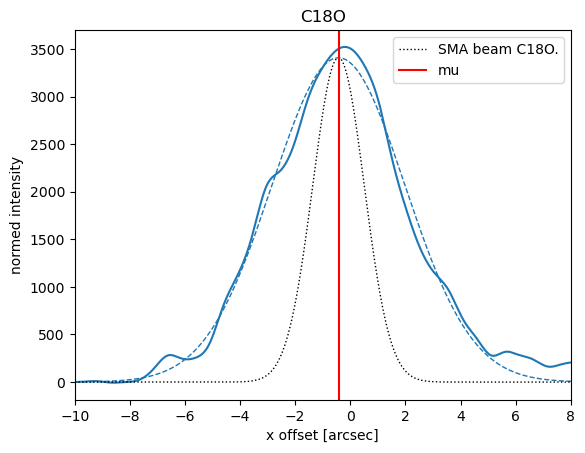

In [68]:
fitter = modeling.fitting.LevMarLSQFitter()
model = modeling.models.Gaussian1D()   # depending on the data you need to give some initial values
fitted_model_C18O = fitter(model, new_grid_centered_C18O, list_centered_C18O[idx_center_C18O])

print('FWHM, mean, sigma, amplitude: ', fitted_model_C18O.fwhm, fitted_model_C18O.mean[0], fitted_model_C18O.stddev[0], fitted_model_C18O.amplitude[0])

plt.plot(new_grid_centered_C18O, list_centered_C18O[idx_center_C18O], c='C0')
plt.plot(new_grid_centered_C18O, fitted_model_C18O(new_grid_centered_C18O), c='C0', ls='--', lw=1)

# overplot Gaussian for the PS1 beam 
FWHM_C18O = 2.2 # arcsec
plt.plot(x_axis, norm.pdf(x_axis,fitted_model_C18O.mean[0],FWHM_C18O/2.355)/np.max(norm.pdf(x_axis,fitted_model_C18O.mean[0],FWHM_C18O/2.355))*np.max(fitted_model_C18O(new_grid_centered_C18O)), c='black', ls=':', lw=1, label='SMA beam C18O.')

plt.axvline(fitted_model_C18O.mean[0], ls='-', c='red', label='mu')


plt.xlabel('x offset [arcsec]')
plt.ylabel('normed intensity')
plt.xlim(-10,8)
plt.legend()
plt.title('C18O')

FWHM_deconv = deconvolve_FWHM(FWHM_C18O, fitted_model_C18O.fwhm)
sigma_deconv = FWHM_deconv/2.355
print('deconvolved FWHM, sigma = ', FWHM_deconv, sigma_deconv)
print('2*sigma, 3*sigma: ', 2*sigma_deconv, 3*sigma_deconv)

#### put everything into one plot

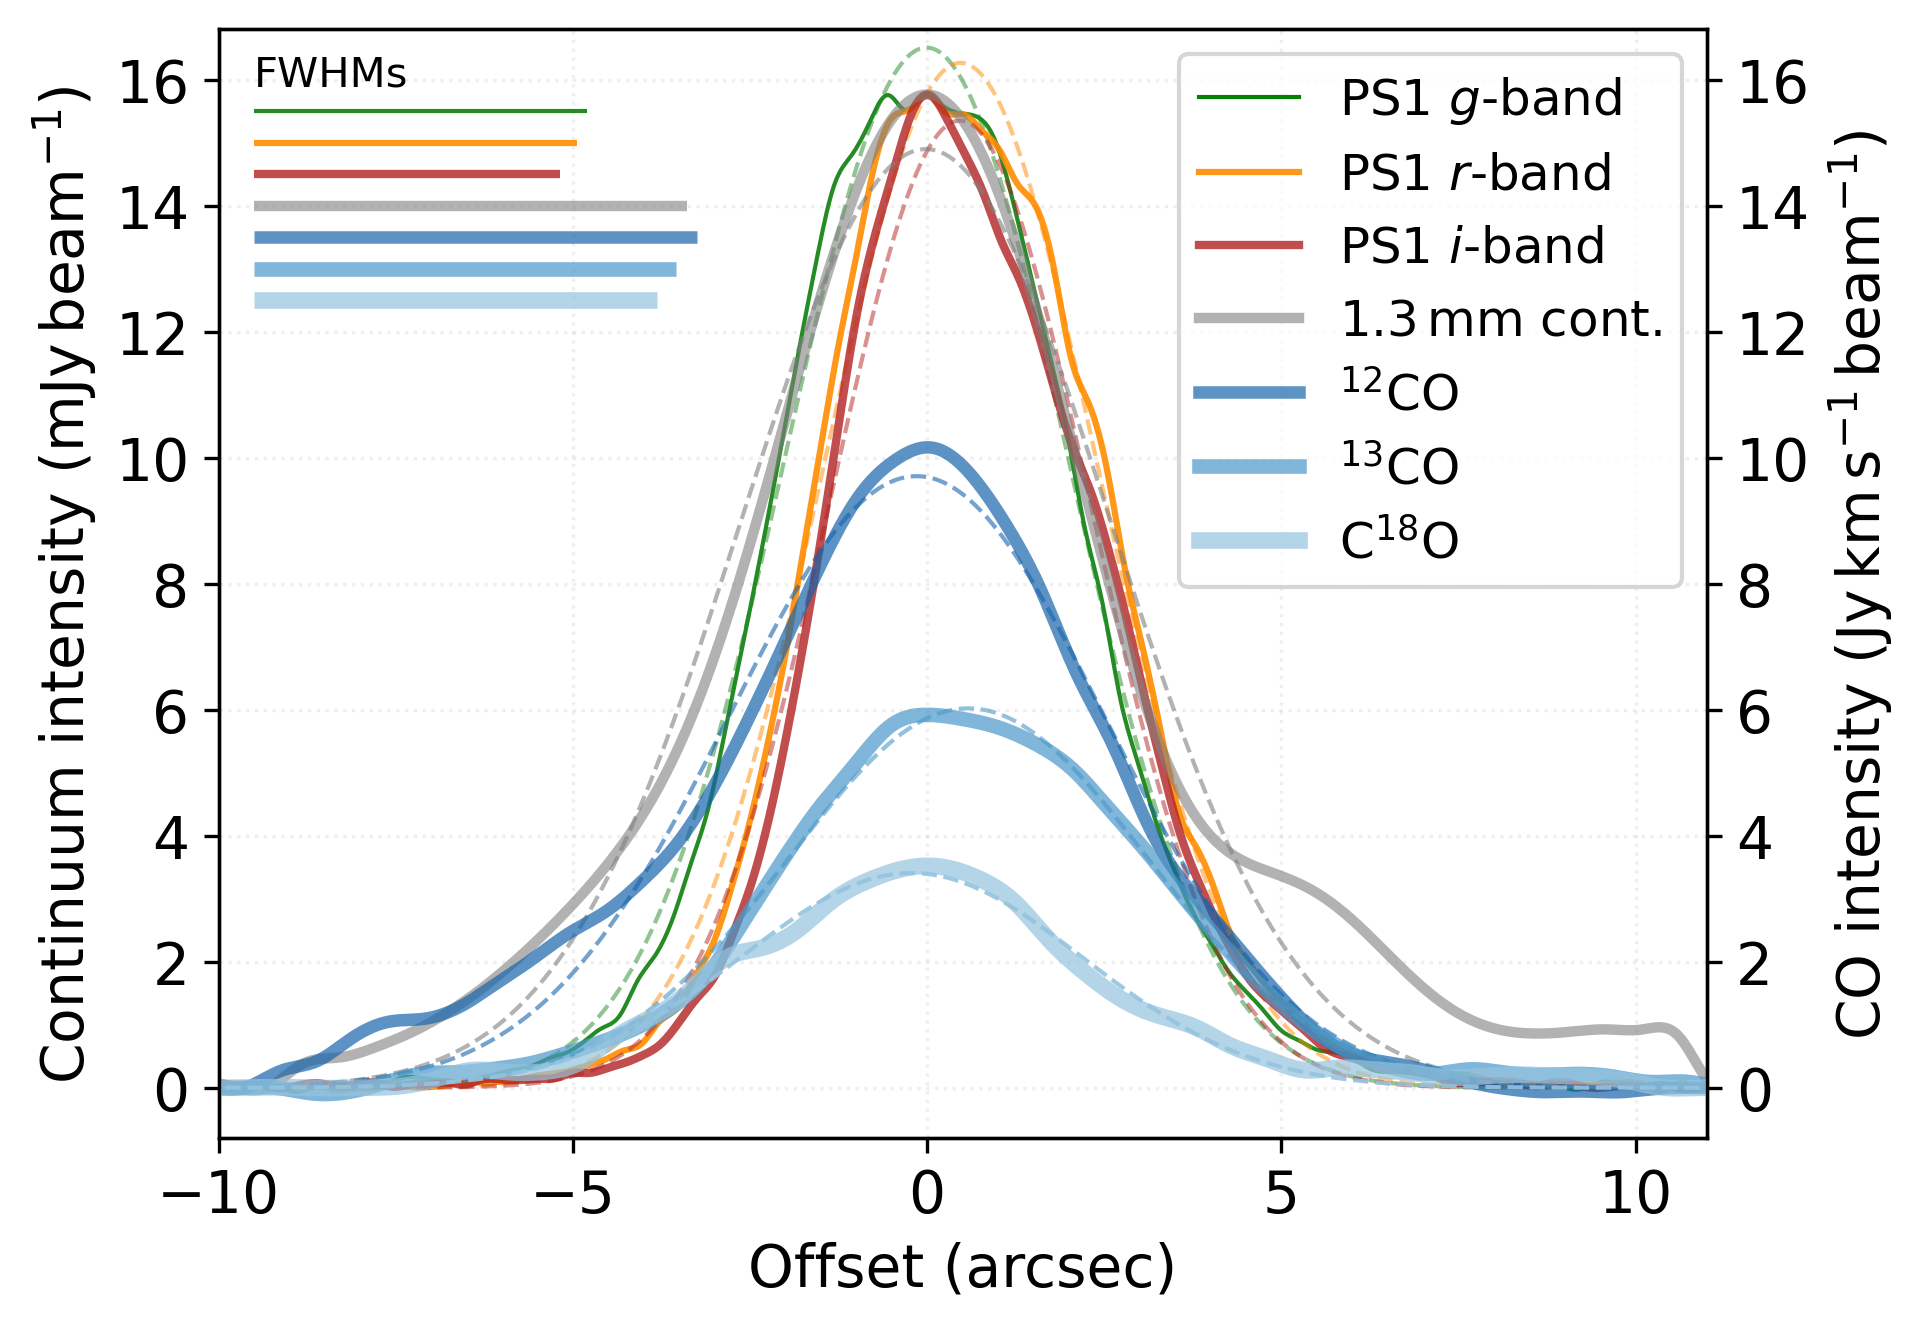

In [69]:
import seaborn as sns

cmap = sns.color_palette('Blues_r', 4)

fig, ax1 = plt.subplots(dpi=300)

plt.grid(ls=':', alpha=0.2)
#plt.axhline(0, ls='--', c='black', alpha=0.2, lw=0.5)

### PS1 gband
ax1.plot(new_grid_centered_gband-mu_gband, 
         list_centered_gband[idx_center_gband]/np.max(list_centered_gband[idx_center_gband])*np.max(list_centered_cont[idx_center_cont])*1000., 
         label='PS1 $g$-band', c='forestgreen', lw=1, alpha=0.99)
ax1.annotate('FWHMs', (-9.5,15.9), c='black')
ax1.plot(new_grid_centered_gband-mu_gband, fitted_model_gband(new_grid_centered_gband)/np.max(list_centered_gband[idx_center_gband])*np.max(list_centered_cont[idx_center_cont])*1000., c='forestgreen', ls='--', lw=1, alpha=0.5)
ax1.hlines(15.5, -9.5, -9.5+fitted_model_gband.fwhm, color='forestgreen', alpha=0.99, lw=1, ls='-')

### PS1 rband
ax1.plot(new_grid_centered_rband-mu_rband, 
         list_centered_rband[idx_center_rband]/np.max(list_centered_rband[idx_center_rband])*np.max(list_centered_cont[idx_center_cont])*1000., 
         label='PS1 $g$-band', c='darkorange', lw=1.5, alpha=0.9)
ax1.plot(new_grid_centered_rband-mu_rband, fitted_model_rband(new_grid_centered_rband)/np.max(list_centered_rband[idx_center_rband])*np.max(list_centered_cont[idx_center_cont])*1000., c='darkorange', ls='--', lw=1, alpha=0.5)
ax1.hlines(15, -9.5, -9.5+fitted_model_rband.fwhm, color='darkorange', alpha=0.9, lw=1.5, ls='-')

### PS1 iband
ax1.plot(new_grid_centered_iband-mu_iband, 
         list_centered_iband[idx_center_iband]/np.max(list_centered_iband[idx_center_iband])*np.max(list_centered_cont[idx_center_cont])*1000., 
         label='PS1 $g$-band', c='firebrick', lw=2, alpha=0.8)
ax1.plot(new_grid_centered_iband-mu_iband, fitted_model_iband(new_grid_centered_iband)/np.max(list_centered_iband[idx_center_iband])*np.max(list_centered_cont[idx_center_cont])*1000., c='firebrick', ls='--', lw=1, alpha=0.5)
ax1.hlines(14.5, -9.5, -9.5+fitted_model_iband.fwhm, color='firebrick', alpha=0.8, lw=2, ls='-')


### 1.3mm continuum
ax1.plot(new_grid_centered_cont-mu_cont, list_centered_cont[idx_center_cont]*1000., 
         label='$1.3\,$mm cont.', c='gray', lw=2.5, alpha=0.6)
ax1.plot(new_grid_centered_cont-mu_cont, fitted_model_cont(new_grid_centered_cont)*1000, c='gray', ls='--', lw=1, alpha=0.6)
ax1.hlines(14, -9.5, -9.5+fitted_model_cont.fwhm, color='gray', alpha=0.6, lw=2.5, ls='-')

ax1.set_xlabel('Offset (arcsec)', fontsize=14)
ax1.set_ylabel('Continuum intensity ($\mathrm{mJy\,beam^{-1}}$)', fontsize=14)
ax1.set_ylim(-0.8,16.8)
ax1.tick_params(axis='both', which='major', labelsize=14)
#ax1.legend()


ax2 = ax1.twinx()

ax2.plot(0,0,label='PS1 $g$-band', c='green', lw=1, alpha=0.99)
ax2.plot(0,0,label='PS1 $r$-band',  c='darkorange', lw=1.5, alpha=0.9)
ax2.plot(0,0,label='PS1 $i$-band',  c='firebrick', lw=2, alpha=0.8)

ax2.plot(0,0, label='$1.3\,$mm cont.', c='gray', lw=2.5, alpha=0.6)

### 12CO
ax2.plot(new_grid_centered_12CO-mu_12CO, list_centered_12CO[idx_center_12CO]/1000., label='$^{12}$CO', c=cmap[0], lw=3, alpha=0.7)
ax2.plot(new_grid_centered_12CO-mu_12CO, fitted_model_12CO(new_grid_centered_12CO)/1000, c=cmap[0], ls='--', lw=1, alpha=0.6)
ax2.hlines(13.5, -9.5, -9.5+fitted_model_12CO.fwhm, color=cmap[0], alpha=0.7, lw=3, ls='-')

### 13CO
ax2.plot(new_grid_centered_13CO-mu_13CO, list_centered_13CO[idx_center_13CO]/1000., label='$^{13}$CO', c=cmap[1], lw=3.5, alpha=0.7)
ax2.plot(new_grid_centered_13CO-mu_13CO, fitted_model_13CO(new_grid_centered_13CO)/1000, c=cmap[1], ls='--', lw=1, alpha=0.6)
ax2.hlines(13, -9.5, -9.5+fitted_model_13CO.fwhm, color=cmap[1], alpha=0.7, lw=3.5, ls='-')

### C18O
ax2.plot(new_grid_centered_C18O-mu_C18O, list_centered_C18O[idx_center_C18O]/1000., label='C$^{18}$O', c=cmap[2], lw=4, alpha=0.7)
ax2.plot(new_grid_centered_C18O-mu_C18O, fitted_model_C18O(new_grid_centered_C18O)/1000, c=cmap[2], ls='--', lw=1, alpha=0.9)
ax2.hlines(12.5, -9.5, -9.5+fitted_model_C18O.fwhm, color=cmap[2], alpha=0.7, lw=4, ls='-')

ax2.set_ylim(-0.8,16.8)

ax2.set_xlim(-10,11)
ax2.set_xlabel('', fontsize=14)
ax2.set_ylabel('CO intensity ($\mathrm{Jy\,km\,s^{-1}\,beam^{-1}}$)', fontsize=14, rotation=90)
ax2.tick_params(axis='both', which='major', labelsize=14)
#plt.xlim(-8,8)
ax2.legend(fontsize=12)


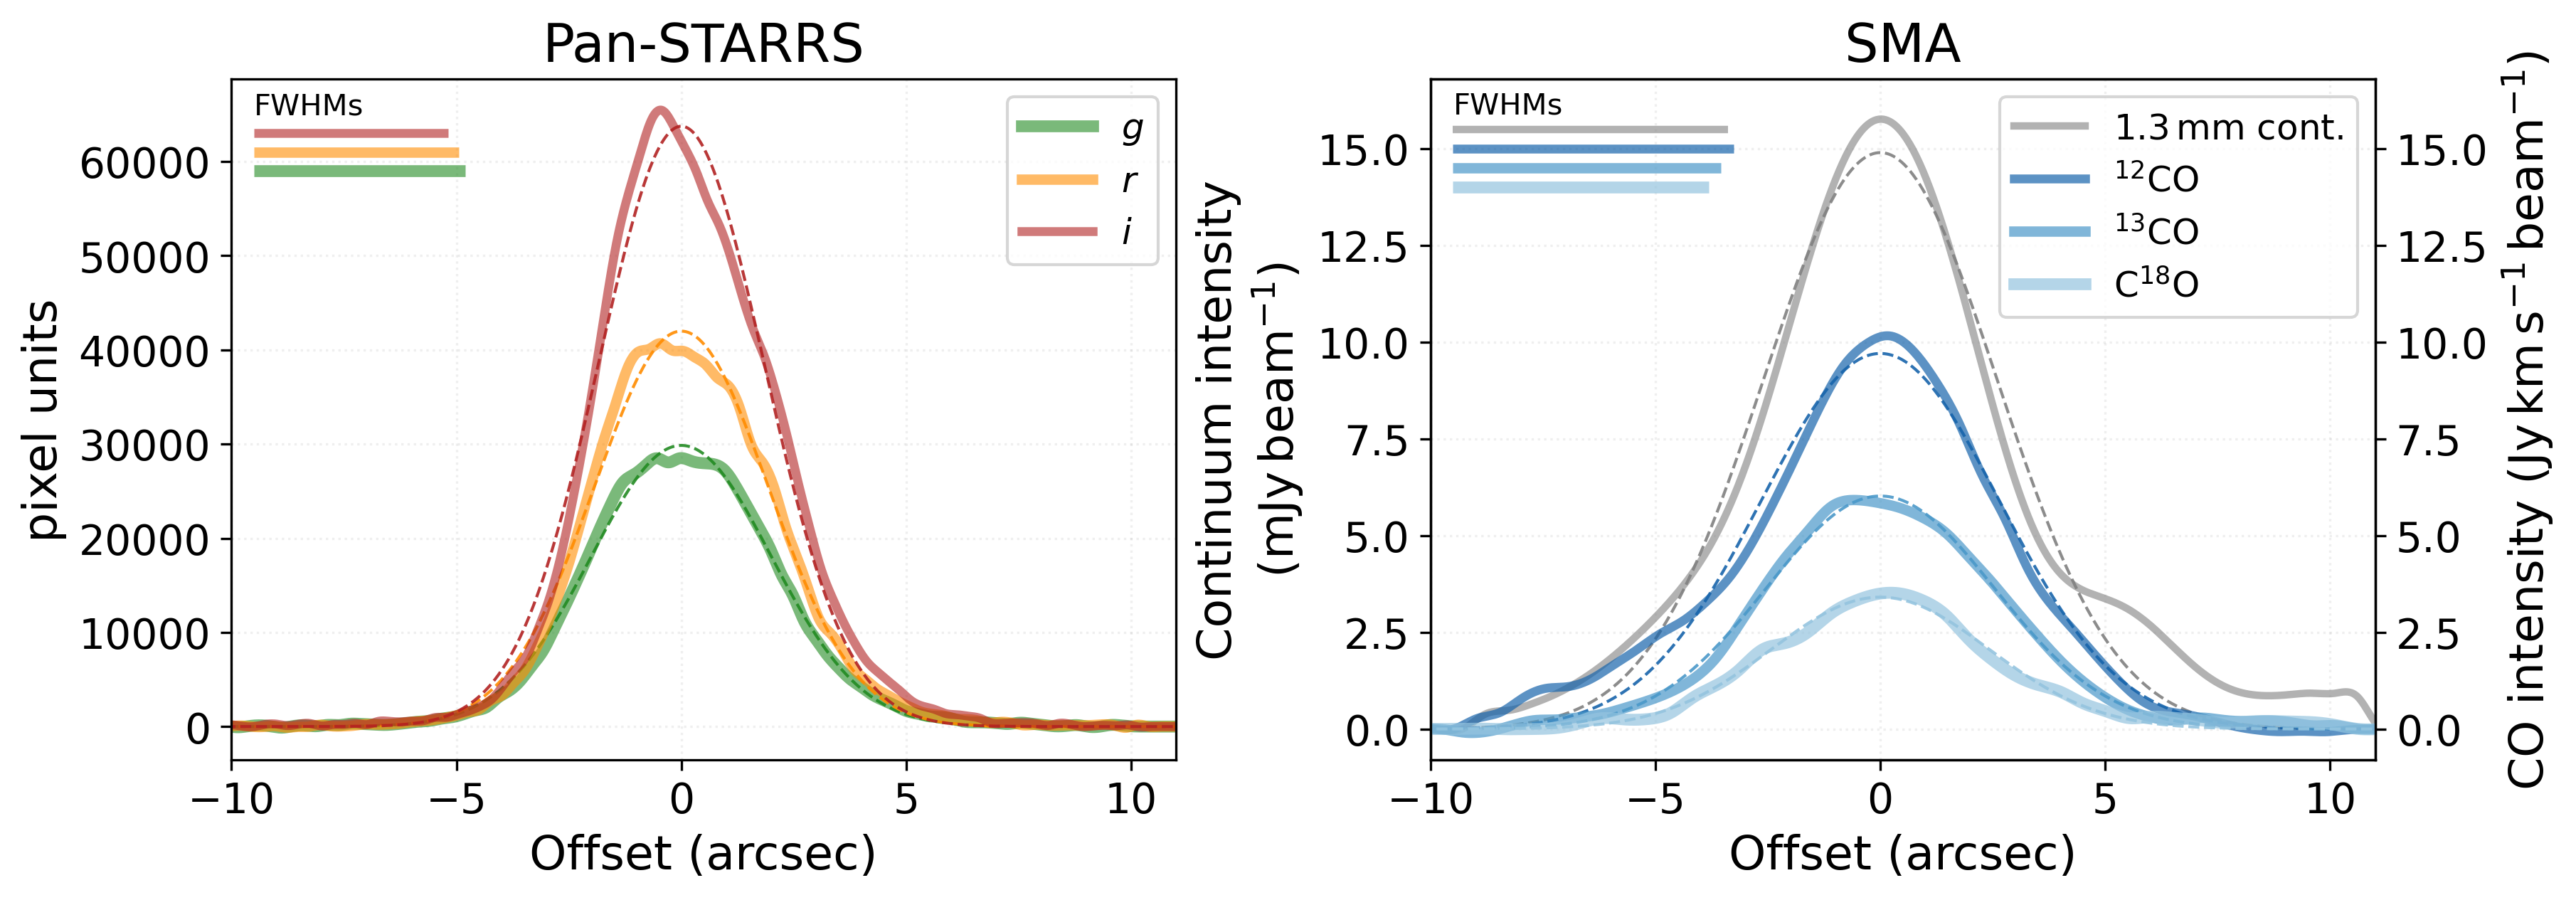

In [70]:
import seaborn as sns

cmap = sns.color_palette('Blues_r', 4)

fig, (ax1, ax2) = plt.subplots(1,2, dpi=300, figsize=(12,5))
fig.tight_layout(pad=5.5)

### PS1 gband
ax1.plot(new_grid_centered_gband-fitted_model_gband.mean[0], 
         list_centered_gband[idx_center_gband], 
         label='$g$', c='forestgreen', lw=4, alpha=0.6)
ax1.annotate('FWHMs', (-9.5,6.5e4), c='black')
ax1.plot(new_grid_centered_gband-fitted_model_gband.mean[0], fitted_model_gband(new_grid_centered_gband), c='forestgreen', ls='--', lw=1, alpha=0.9)
ax1.hlines(5.9e4, -9.5, -9.5+fitted_model_gband.fwhm, color='forestgreen', alpha=0.6, lw=4, ls='-')

### PS1 rband
ax1.plot(new_grid_centered_rband-fitted_model_rband.mean[0], 
         list_centered_rband[idx_center_rband], 
         label='$r$', c='darkorange', lw=3.5, alpha=0.6)
ax1.plot(new_grid_centered_rband-fitted_model_rband.mean[0], fitted_model_rband(new_grid_centered_rband), c='darkorange', ls='--', lw=1, alpha=0.9)
ax1.hlines(6.1e4, -9.5, -9.5+fitted_model_rband.fwhm, color='darkorange', alpha=0.6, lw=3.5, ls='-')

### PS1 iband
ax1.plot(new_grid_centered_iband-fitted_model_iband.mean[0], 
         list_centered_iband[idx_center_iband], 
         label='$i$', c='firebrick', lw=3, alpha=0.6)
ax1.plot(new_grid_centered_iband-fitted_model_iband.mean[0], fitted_model_iband(new_grid_centered_iband), c='firebrick', ls='--', lw=1, alpha=0.9)
ax1.hlines(6.3e4, -9.5, -9.5+fitted_model_iband.fwhm, color='firebrick', alpha=0.6, lw=3, ls='-')


ax1.legend(fontsize=12)

ax1.set_xlabel('Offset (arcsec)', fontsize=16)
#ax1.set_ylim(-0.8,16.8)
ax1.set_xlim(-10,11)
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.set_ylabel('pixel units', fontsize=16)
ax1.grid(ls=':', alpha=0.2)
ax1.set_title('Pan-STARRS', fontsize=18)

### 1.3mm continuum
ax2.plot(new_grid_centered_cont-fitted_model_cont.mean[0], list_centered_cont[idx_center_cont]*1000., 
         label='$1.3\,$mm cont.', c='gray', lw=2.5, alpha=0.6)
ax2.plot(new_grid_centered_cont-fitted_model_cont.mean[0], fitted_model_cont(new_grid_centered_cont)*1000, c='gray', ls='--', lw=1, alpha=0.9)
ax2.annotate('FWHMs', (-9.5,15.9), c='black')
ax2.hlines(15.5, -9.5, -9.5+fitted_model_cont.fwhm, color='gray', alpha=0.6, lw=2.5, ls='-')


ax3 = ax2.twinx()

ax3.plot(0,0, label='$1.3\,$mm cont.', c='gray', lw=2.5, alpha=0.6)

### 12CO
ax3.plot(new_grid_centered_12CO-fitted_model_12CO.mean[0], list_centered_12CO[idx_center_12CO]/1000., label='$^{12}$CO', c=cmap[0], lw=3, alpha=0.7)
ax3.plot(new_grid_centered_12CO-fitted_model_12CO.mean[0], fitted_model_12CO(new_grid_centered_12CO)/1000, c=cmap[0], ls='--', lw=1, alpha=0.9)
ax3.hlines(15., -9.5, -9.5+fitted_model_12CO.fwhm, color=cmap[0], alpha=0.7, lw=3, ls='-')

### 13CO
ax3.plot(new_grid_centered_13CO-fitted_model_13CO.mean[0], list_centered_13CO[idx_center_13CO]/1000., label='$^{13}$CO', c=cmap[1], lw=3.5, alpha=0.7)
ax3.plot(new_grid_centered_13CO-fitted_model_13CO.mean[0], fitted_model_13CO(new_grid_centered_13CO)/1000, c=cmap[1], ls='--', lw=1, alpha=0.9)
ax3.hlines(14.5, -9.5, -9.5+fitted_model_13CO.fwhm, color=cmap[1], alpha=0.7, lw=3.5, ls='-')

### C18O
ax3.plot(new_grid_centered_C18O-fitted_model_C18O.mean[0], list_centered_C18O[idx_center_C18O]/1000., label='C$^{18}$O', c=cmap[2], lw=4, alpha=0.7)
ax3.plot(new_grid_centered_C18O-fitted_model_C18O.mean[0], fitted_model_C18O(new_grid_centered_C18O)/1000, c=cmap[2], ls='--', lw=1, alpha=0.9)
ax3.hlines(14., -9.5, -9.5+fitted_model_C18O.fwhm, color=cmap[2], alpha=0.7, lw=4, ls='-')

ax2.set_ylim(-0.8,16.8)
ax2.set_xlim(-10,11)
ax2.set_xlabel('Offset (arcsec)', fontsize=16)
ax2.set_ylabel('Continuum intensity\n($\mathrm{mJy\,beam^{-1}}$)', fontsize=16)
ax2.tick_params(axis='both', which='major', labelsize=14)


ax3.set_ylabel('CO intensity ($\mathrm{Jy\,km\,s^{-1}\,beam^{-1}}$)', fontsize=16, rotation=90)
ax3.tick_params(axis='both', which='major', labelsize=14)
ax3.set_ylim(-0.8,16.8)
ax3.set_xlim(-10,11)
ax3.set_title('SMA', fontsize=18)

#plt.xlim(-8,8)
ax3.legend(fontsize=12)
ax2.grid(ls=':', alpha=0.2)

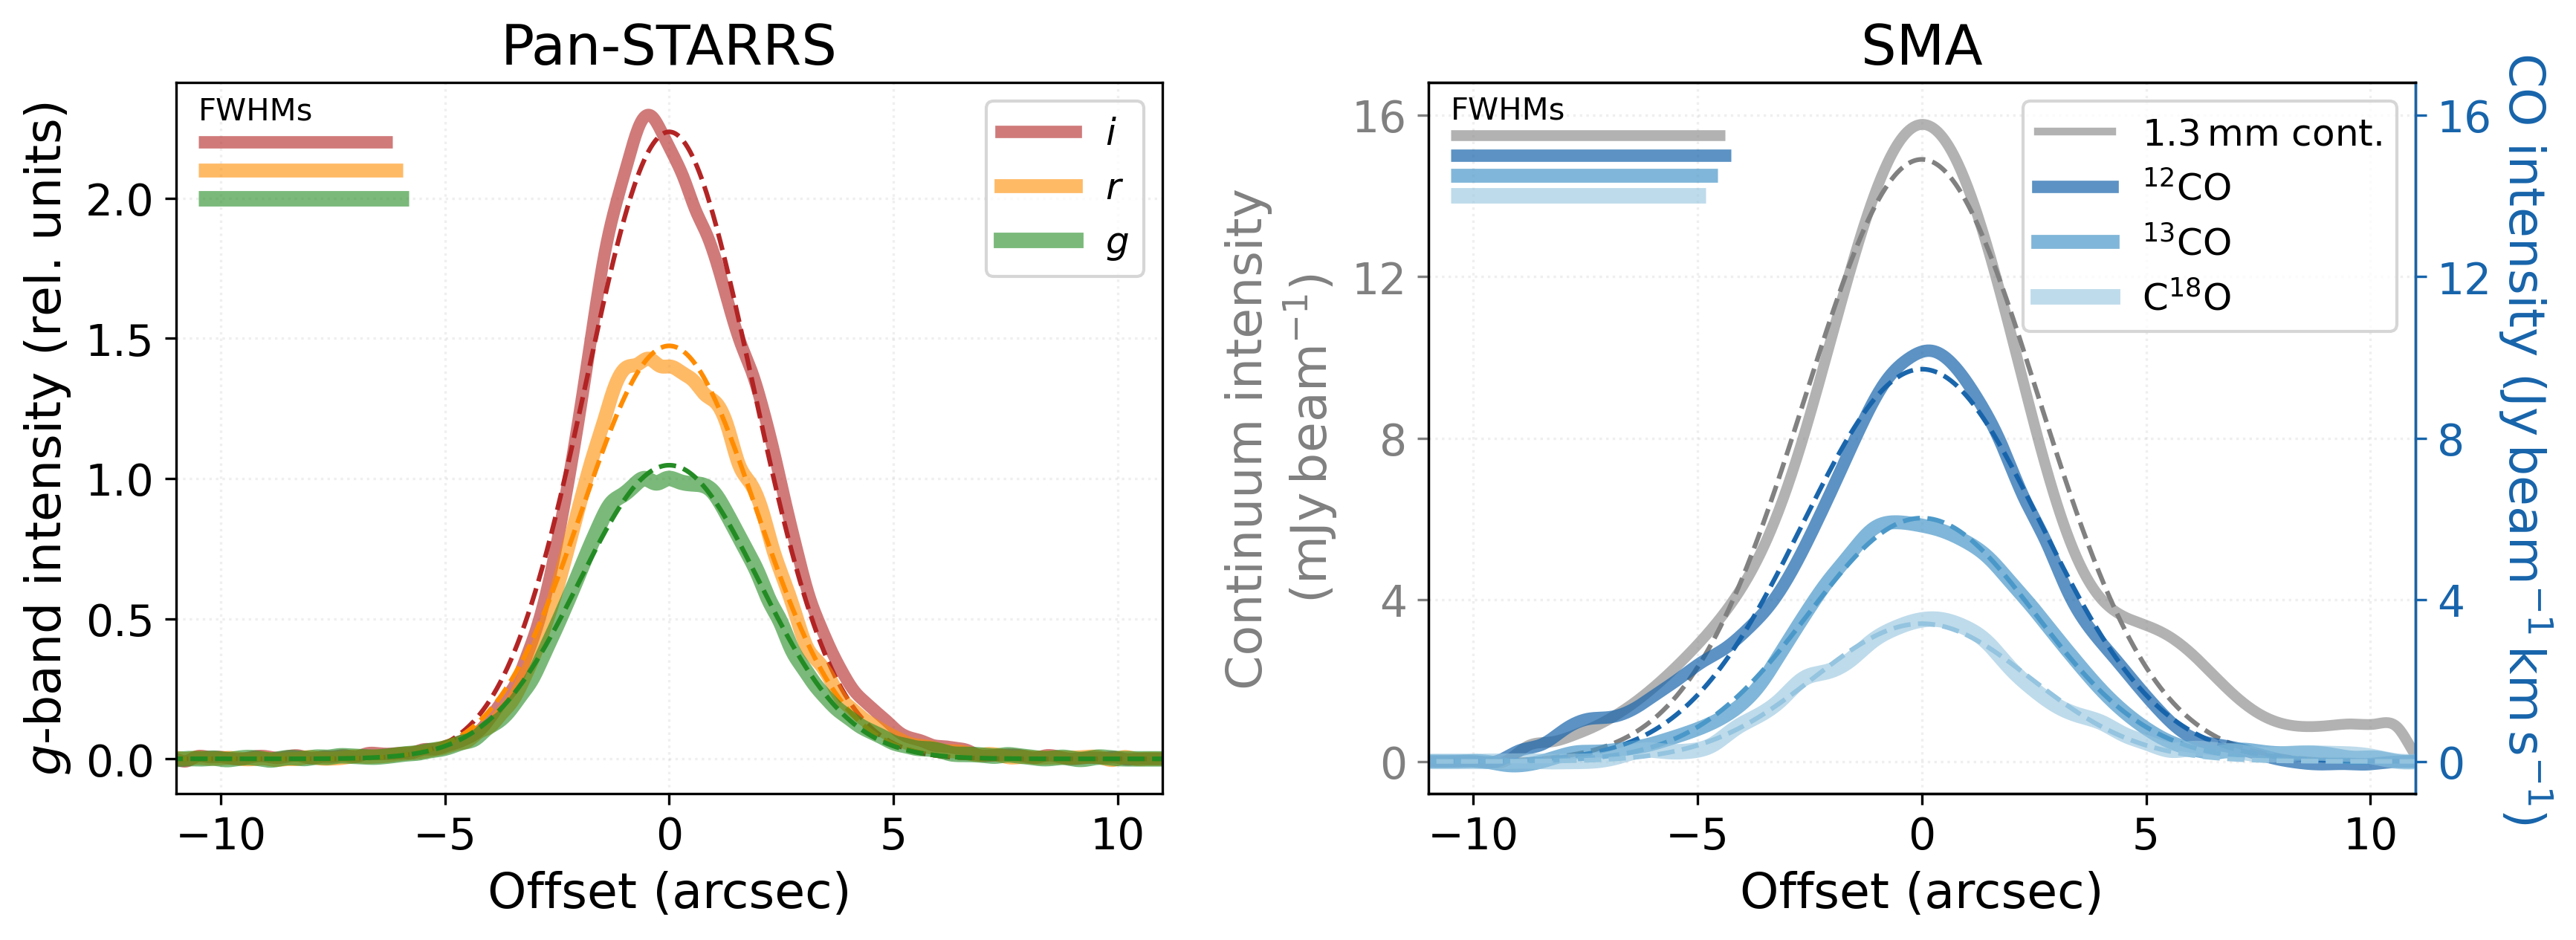

In [71]:
import seaborn as sns

cmap = sns.color_palette('Blues_r', 4)

fig, (ax1, ax2) = plt.subplots(1,2, dpi=300, figsize=(12,5))
fig.tight_layout(pad=5.5)


### PS1 iband
ax1.plot(new_grid_centered_iband-fitted_model_iband.mean[0], 
         list_centered_iband[idx_center_iband]/np.max(list_centered_gband[idx_center_gband]), 
         label='$i$', c='firebrick', lw=4, alpha=0.6)
ax1.plot(new_grid_centered_iband-fitted_model_iband.mean[0], fitted_model_iband(new_grid_centered_iband)/np.max(list_centered_gband[idx_center_gband]), 
         c='firebrick', ls='--', lw=1.5, alpha=0.99)
ax1.hlines(2.2, -10.5, -10.5+fitted_model_iband.fwhm, color='firebrick', alpha=0.6, lw=4, ls='-')


### PS1 rband
ax1.plot(new_grid_centered_rband-fitted_model_rband.mean[0], 
         list_centered_rband[idx_center_rband]/np.max(list_centered_gband[idx_center_gband]), 
         label='$r$', c='darkorange', lw=4.5, alpha=0.6)
ax1.plot(new_grid_centered_rband-fitted_model_rband.mean[0], fitted_model_rband(new_grid_centered_rband)/np.max(list_centered_gband[idx_center_gband]), 
         c='darkorange', ls='--', lw=1.5, alpha=0.999)
ax1.hlines(2.1, -10.5, -10.5+fitted_model_rband.fwhm, color='darkorange', alpha=0.6, lw=4.5, ls='-')

### PS1 gband
ax1.plot(new_grid_centered_gband-fitted_model_gband.mean[0], 
         list_centered_gband[idx_center_gband]/np.max(list_centered_gband[idx_center_gband]), 
         label='$g$', c='forestgreen', lw=5, alpha=0.6)
ax1.annotate('FWHMs', (-10.5,2.28), c='black')
ax1.plot(new_grid_centered_gband-fitted_model_gband.mean[0], fitted_model_gband(new_grid_centered_gband)/np.max(list_centered_gband[idx_center_gband]), 
         c='forestgreen', ls='--', lw=1.5, alpha=0.99)
ax1.hlines(2.0, -10.5, -10.5+fitted_model_gband.fwhm, color='forestgreen', alpha=0.6, lw=5, ls='-')



ax1.legend(fontsize=12)

ax1.set_xlabel('Offset (arcsec)', fontsize=16)
#ax1.set_ylim(-0.8,16.8)
ax1.set_xlim(-11,11)
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.set_ylabel('$g$-band intensity (rel. units)', fontsize=16)
ax1.grid(ls=':', alpha=0.2)
ax1.set_title('Pan-STARRS', fontsize=18)

### 1.3mm continuum
ax2.plot(new_grid_centered_cont-fitted_model_cont.mean[0], list_centered_cont[idx_center_cont]*1000., 
         label='$1.3\,$mm cont.', c='gray', lw=3.5, alpha=0.6)
ax2.plot(new_grid_centered_cont-fitted_model_cont.mean[0], fitted_model_cont(new_grid_centered_cont)*1000, 
         c='gray', ls='--', lw=1.5, alpha=0.99)
ax2.annotate('FWHMs', (-10.5,15.9), c='black')
ax2.hlines(15.5, -10.5, -10.5+fitted_model_cont.fwhm, color='gray', alpha=0.6, lw=3.5, ls='-')

ax2.set_ylim(-0.8,16.8)
ax2.set_xlim(-10,11)
ax2.set_xlabel('Offset (arcsec)', fontsize=16)
ax2.set_ylabel('Continuum intensity\n($\mathrm{mJy\,beam^{-1}}$)', fontsize=16, c='gray')
ax2.tick_params(axis='both', which='both', labelsize=14) 
ax2.tick_params(axis='y', which='both', labelsize=14, colors='gray') 
ax2.set_yticks([0,4,8,12,16])

ax2.spines['left'].set_color('gray')

ax3 = ax2.twinx()

ax3.plot(0,0, label='$1.3\,$mm cont.', c='gray', lw=2.5, alpha=0.6)

### 12CO
ax3.plot(new_grid_centered_12CO-fitted_model_12CO.mean[0], list_centered_12CO[idx_center_12CO]/1000., 
         label='$^{12}$CO', c=cmap[0], lw=4, alpha=0.7)
ax3.plot(new_grid_centered_12CO-fitted_model_12CO.mean[0], fitted_model_12CO(new_grid_centered_12CO)/1000, 
         c=cmap[0], ls='--', lw=1.5, alpha=0.99)
ax3.hlines(15., -10.5, -10.5+fitted_model_12CO.fwhm, color=cmap[0], alpha=0.7, lw=4, ls='-')

### 13CO
ax3.plot(new_grid_centered_13CO-fitted_model_13CO.mean[0], list_centered_13CO[idx_center_13CO]/1000., 
         label='$^{13}$CO', c=cmap[1], lw=4.5, alpha=0.7)
ax3.plot(new_grid_centered_13CO-fitted_model_13CO.mean[0], fitted_model_13CO(new_grid_centered_13CO)/1000, 
         c=cmap[1], ls='--', lw=1.5, alpha=0.99)
ax3.hlines(14.5, -10.5, -10.5+fitted_model_13CO.fwhm, color=cmap[1], alpha=0.7, lw=4.5, ls='-')

### C18O
ax3.plot(new_grid_centered_C18O-fitted_model_C18O.mean[0], list_centered_C18O[idx_center_C18O]/1000., 
         label='C$^{18}$O', c=cmap[2], lw=5, alpha=0.6)
ax3.plot(new_grid_centered_C18O-fitted_model_C18O.mean[0], fitted_model_C18O(new_grid_centered_C18O)/1000, 
         c=cmap[2], ls='--', lw=1.5, alpha=0.99)
ax3.hlines(14., -10.5, -10.5+fitted_model_C18O.fwhm, color=cmap[2], alpha=0.6, lw=5, ls='-')


ax3.set_ylabel('CO intensity ($\mathrm{Jy\,beam^{-1}\,km\,s^{-1}}$)', fontsize=16, rotation=270, c=cmap[0], labelpad=20)
ax3.tick_params(axis='both', which='both', labelsize=14, colors=cmap[0]) 
ax3.spines['right'].set_color(cmap[0])
ax3.set_ylim(-0.8,16.8)
ax3.set_yticks([0,4,8,12,16])
ax3.set_xlim(-11,11)
ax3.set_title('SMA', fontsize=18)

#plt.xlim(-8,8)
ax3.legend(fontsize=12)
ax2.grid(ls=':', alpha=0.2)

fig.savefig('/Users/kristina/Hamburgers/Draculas_Chivito/plots/paper_plots/radial_intensity.pdf', bbox_inches='tight')


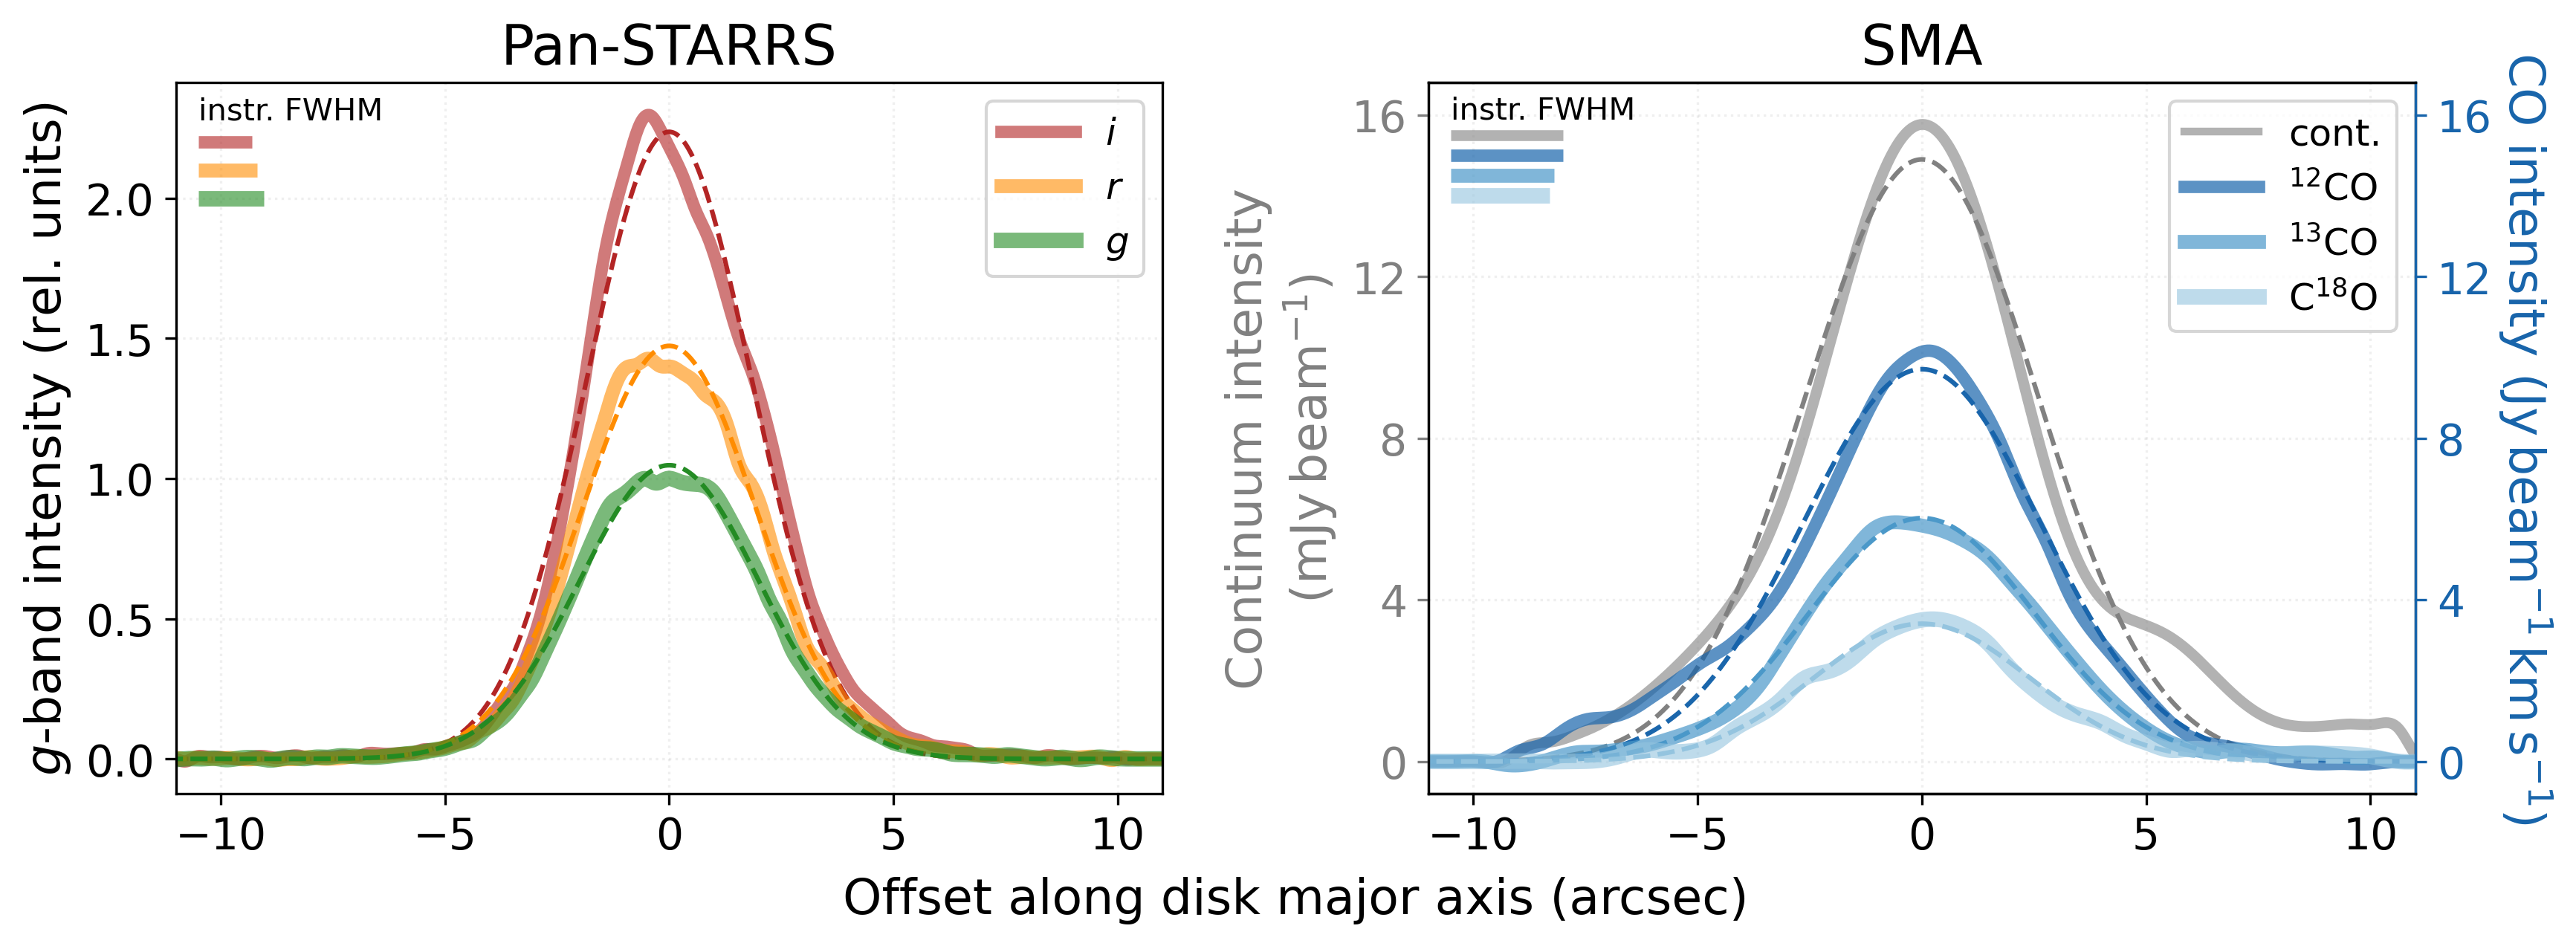

In [72]:
import seaborn as sns

cmap = sns.color_palette('Blues_r', 4)

fig, (ax1, ax2) = plt.subplots(1,2, dpi=300, figsize=(12,5))
fig.tight_layout(pad=5.5)

ax1.annotate('instr. FWHM', (-10.5,2.28), c='black')

### PS1 iband
ax1.plot(new_grid_centered_iband-fitted_model_iband.mean[0], 
         list_centered_iband[idx_center_iband]/np.max(list_centered_gband[idx_center_gband]), 
         label='$i$', c='firebrick', lw=4, alpha=0.6)
ax1.plot(new_grid_centered_iband-fitted_model_iband.mean[0], fitted_model_iband(new_grid_centered_iband)/np.max(list_centered_gband[idx_center_gband]), 
         c='firebrick', ls='--', lw=1.5, alpha=0.99)
ax1.hlines(2.2, -10.5, -10.5+FWHM_iband, color='firebrick', alpha=0.6, lw=4, ls='-')


### PS1 rband
ax1.plot(new_grid_centered_rband-fitted_model_rband.mean[0], 
         list_centered_rband[idx_center_rband]/np.max(list_centered_gband[idx_center_gband]), 
         label='$r$', c='darkorange', lw=4.5, alpha=0.6)
ax1.plot(new_grid_centered_rband-fitted_model_rband.mean[0], fitted_model_rband(new_grid_centered_rband)/np.max(list_centered_gband[idx_center_gband]), 
         c='darkorange', ls='--', lw=1.5, alpha=0.999)
ax1.hlines(2.1, -10.5, -10.5+FWHM_rband, color='darkorange', alpha=0.6, lw=4.5, ls='-')

### PS1 gband
ax1.plot(new_grid_centered_gband-fitted_model_gband.mean[0], 
         list_centered_gband[idx_center_gband]/np.max(list_centered_gband[idx_center_gband]), 
         label='$g$', c='forestgreen', lw=5, alpha=0.6)

ax1.plot(new_grid_centered_gband-fitted_model_gband.mean[0], fitted_model_gband(new_grid_centered_gband)/np.max(list_centered_gband[idx_center_gband]), 
         c='forestgreen', ls='--', lw=1.5, alpha=0.99)
ax1.hlines(2.0, -10.5, -10.5+FWHM_gband, color='forestgreen', alpha=0.6, lw=5, ls='-')



ax1.legend(fontsize=12)

ax1.set_xlabel('', fontsize=16)
#ax1.set_ylim(-0.8,16.8)
ax1.set_xlim(-11,11)
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.set_ylabel('$g$-band intensity (rel. units)', fontsize=16)
ax1.grid(ls=':', alpha=0.2)
ax1.set_title('Pan-STARRS', fontsize=18)

### 1.3mm continuum
ax2.plot(new_grid_centered_cont-fitted_model_cont.mean[0], list_centered_cont[idx_center_cont]*1000., 
         label='$1.3\,$mm cont.', c='gray', lw=3.5, alpha=0.6)
ax2.plot(new_grid_centered_cont-fitted_model_cont.mean[0], fitted_model_cont(new_grid_centered_cont)*1000, 
         c='gray', ls='--', lw=1.5, alpha=0.99)
ax2.annotate('instr. FWHM', (-10.5,15.9), c='black')
ax2.hlines(15.5, -10.5, -10.5+FWHM_cont, color='gray', alpha=0.6, lw=3.5, ls='-')

ax2.set_ylim(-0.8,16.8)
ax2.set_xlim(-10,11)
ax2.set_xlabel('', fontsize=16)
ax2.set_ylabel('Continuum intensity\n($\mathrm{mJy\,beam^{-1}}$)', fontsize=16, c='gray')
ax2.tick_params(axis='both', which='both', labelsize=14) 
ax2.tick_params(axis='y', which='both', labelsize=14, colors='gray') 
ax2.set_yticks([0,4,8,12,16])

ax2.spines['left'].set_color('gray')

ax3 = ax2.twinx()

ax3.plot(0,0, label='cont.', c='gray', lw=2.5, alpha=0.6)

### 12CO
ax3.plot(new_grid_centered_12CO-fitted_model_12CO.mean[0], list_centered_12CO[idx_center_12CO]/1000., 
         label='$^{12}$CO', c=cmap[0], lw=4, alpha=0.7)
ax3.plot(new_grid_centered_12CO-fitted_model_12CO.mean[0], fitted_model_12CO(new_grid_centered_12CO)/1000, 
         c=cmap[0], ls='--', lw=1.5, alpha=0.99)
ax3.hlines(15., -10.5, -10.5+FWHM_12CO, color=cmap[0], alpha=0.7, lw=4, ls='-')

### 13CO
ax3.plot(new_grid_centered_13CO-fitted_model_13CO.mean[0], list_centered_13CO[idx_center_13CO]/1000., 
         label='$^{13}$CO', c=cmap[1], lw=4.5, alpha=0.7)
ax3.plot(new_grid_centered_13CO-fitted_model_13CO.mean[0], fitted_model_13CO(new_grid_centered_13CO)/1000, 
         c=cmap[1], ls='--', lw=1.5, alpha=0.99)
ax3.hlines(14.5, -10.5, -10.5+FWHM_13CO, color=cmap[1], alpha=0.7, lw=4.5, ls='-')

### C18O
ax3.plot(new_grid_centered_C18O-fitted_model_C18O.mean[0], list_centered_C18O[idx_center_C18O]/1000., 
         label='C$^{18}$O', c=cmap[2], lw=5, alpha=0.6)
ax3.plot(new_grid_centered_C18O-fitted_model_C18O.mean[0], fitted_model_C18O(new_grid_centered_C18O)/1000, 
         c=cmap[2], ls='--', lw=1.5, alpha=0.99)
ax3.hlines(14., -10.5, -10.5+FWHM_C18O, color=cmap[2], alpha=0.6, lw=5, ls='-')


ax3.set_ylabel('CO intensity ($\mathrm{Jy\,beam^{-1}\,km\,s^{-1}}$)', fontsize=16, rotation=270, c=cmap[0], labelpad=20)
ax3.tick_params(axis='both', which='both', labelsize=14, colors=cmap[0]) 
ax3.spines['right'].set_color(cmap[0])
ax3.set_ylim(-0.8,16.8)
ax3.set_yticks([0,4,8,12,16])
ax3.set_xlim(-11,11)
ax3.set_title('SMA', fontsize=18)

#plt.xlim(-8,8)
ax3.legend(fontsize=12)
ax2.grid(ls=':', alpha=0.2)

fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("Offset along disk major axis (arcsec)", fontsize=16, labelpad=10)

fig.savefig('/Users/kristina/Hamburgers/Draculas_Chivito/plots/paper_plots/radial_intensity.pdf', bbox_inches='tight')
